In [1]:
from train_SimCLR_utils import *
import torch
from torch.utils.data import DataLoader
from dataset.dataset_loader import SNDataset,SNDatasetClimate, myNormalize, myToTensor, Augmentations
from torchvision import transforms
import random
import numpy as np
from dataset.utils.utils import TextColors as tc
from plot_utils.plot import plot_train_test_losses
from datetime import date, datetime
import torch.nn.functional as F
import cv2
import json

In [2]:
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

In [3]:
# Format the date and time
now = datetime.now()
start_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", start_string)

Current Date and Time: 2023-12-12 12:19:09


In [4]:
import os
os.getcwd()

NAFISEH = "Nafiseh"
MOIEN = "Moien"

if "d:" in os.getcwd():
    USER = MOIEN
elif "c:" in os.getcwd():
    USER = NAFISEH
else:
    raise Exception("Unknown user")

USER

'Nafiseh'

In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
# CONFIG
NUM_WORKERS = 6 if USER == NAFISEH else 2
TRAIN_BATCH_SIZE = 32 if USER == NAFISEH else 4
TEST_BATCH_SIZE = 32 if USER == NAFISEH else 4
LEARNING_RATE = 1e-4 if USER == NAFISEH else 1e-4
NUM_EPOCHS = 50 if USER == NAFISEH else 2
LR_SCHEDULER = "step" # step, plateau or None

OC_MAX = 87
USE_SRTM = True

USE_SPATIAL_ATTENTION = False if USER == NAFISEH else False
CNN_ARCHITECTURE = 'ViT' # vgg16 or resnet101 or "ViT"
RNN_ARCHITECTURE = 'LSTM' # LSTM, GRU, RNN, Transformer
REG_VERSION = 1 if USER == NAFISEH else 2
USE_LSTM_BRANCH = True

In [7]:

if USE_SRTM:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)], [(12), (-4,2963)], [(13), (0, 90)]], oc_min = 0, oc_max = OC_MAX)
else:
    mynorm = myNormalize(img_bands_min_max =[[(0,7),(0,1)], [(7,12),(-1,1)]], oc_min = 0, oc_max = OC_MAX)
    
my_to_tensor = myToTensor()
my_augmentation = Augmentations()
train_transform = transforms.Compose([mynorm, my_to_tensor,my_augmentation])
test_transform = transforms.Compose([mynorm, my_to_tensor])

In [8]:
if USER == MOIEN:
    train_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\train\\'
    test_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\test\\'
    val_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\val\\'
    testval_l8_folder_path = 'D:\python\SoilNet\dataset\l8_images\\val\\'
    lucas_csv_path = 'D:\python\SoilNet\dataset\LUCAS_2015_all.csv'
    climate_csv_folder_path = "D:\\python\\SoilNet\\dataset\\Climate\\All\\filled\\"
    
elif USER == NAFISEH:
    train_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images\\train'
    
    test_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images\\val'
    val_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images\\val'
    testval_l8_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\l8_images\\test_val'
    # lucas_csv_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-3\\SoilNet\\dataset\\LUCAS_2015_all.csv'
    lucas_csv_path = "C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\simclr\\simclr.csv" # The LUCAS will be replaced by SimCLR file
    climate_csv_folder_path = 'C:\\Users\\nkakhani\\_Multimodal\\SoilNet-7\\SoilNet-PreRelease\\dataset\\Climate\\All\\filled'

In [9]:
bands = [0,1,2,3,4,5,6,7,8,9,10,11] if not USE_SRTM else [0,1,2,3,4,5,6,7,8,9,10,11,12,13]


################################# IF Not USE_LSTM_BRANCH ###############################
if not USE_LSTM_BRANCH: # NOT USING THE CLIMATE DATA

    train_ds = SNDataset(train_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=train_transform)
    test_ds =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    val_ds = SNDataset(val_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform)
    test_ds_w_id =  SNDataset(test_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    testval_ds_w_id =  SNDataset(testval_l8_folder_path, lucas_csv_path,l8_bands=bands, transform=test_transform, return_point_id=True)
    
################################### IF USE_LSTM_BRANCH #################################
else: # USING THE CLIMATE DATA
    train_ds = SNDatasetClimate(train_l8_folder_path,
                                    lucas_csv_path,
                                    climate_csv_folder_path,
                                    l8_bands=bands, transform=train_transform)

    test_ds = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    val_ds = SNDatasetClimate(val_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform)
    
    test_ds_w_id = SNDatasetClimate(test_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)

    testval_ds_w_id = SNDatasetClimate(testval_l8_folder_path,
                                lucas_csv_path,
                                climate_csv_folder_path,
                                l8_bands=bands, transform=test_transform, return_point_id=True)
    


In [10]:
SEQ_LEN = testval_ds_w_id[0][0][1].shape[0]
SEQ_LEN # max sequence length for Transformer model set up

61

In [11]:
# COUNTING the csv files in the csv folder
CSV_FILES = [f for f in os.listdir(climate_csv_folder_path) if f.endswith('.csv')]
NUM_CLIMATE_FEATURES = len(CSV_FILES)
NUM_CLIMATE_FEATURES

11

In [12]:
from soilnet.soil_net import SoilNet, SoilNetLSTM, SoilNetSimCLR

__name__: submodules.src.transformer.transformer


In [13]:
# train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# # Get image and label from custom DataLoader
# img_custom, climate,label_custom = next(iter(train_dl))
# print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
# print(f"Climate shape: {climate.shape} -> [batch_size, climate_channels]")
# print(f"Label shape: {label_custom.shape}")
# img_gpu = img_custom.to(device)
# print(img_gpu.device, img_gpu.shape)
# print(img_gpu.shape)
# y = model(img_gpu)
# y.detach()

In [14]:
cv_results = {"train_loss": [],
                "train_acc_top1": [],
                "train_acc_top5": [],
                "train_acc_mean_pos": [],
                "val_loss": [],
                "val_acc_top1": [],
                "val_acc_top5": [],
                "val_acc_mean_pos": [],
    }

In [15]:
from datetime import date, datetime
# Format the date and time
now = datetime.now()
run_name = now.strftime("D_%Y_%m_%d_T_%H_%M")
print("Current Date and Time:", run_name)
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

Current Date and Time: D_2023_12_12_T_12_19


In [16]:
# SEEDS = [75] 
SEEDS = [1]  if USER == MOIEN else [1, 4, 69, 75, 79]
# SEEDS = [1] if USER == MOIEN else [1, 4, 69, 75, 79, 128, 474, 786, 2048, 3333]

In [17]:
best_mae = 1000 # just a big number, since our data is normalized between 0 and 1, mae is between 0 and 1 too.
best_seed = SEEDS[0]
for idx, seed in enumerate(SEEDS):
    print(tc.BOLD_BAKGROUNDs.PURPLE, f"CROSS VAL {idx+1}", tc.ENDC)
    
    
    train_dl = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    test_dl = DataLoader(test_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    val_dl = DataLoader(val_ds, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    
    #model = SoilNetFC(cnn_in_channels=12, regresor_input_from_cnn=1024, hidden_size=128).to(device)
    # architecture = "101+GLAM" if USE_SPATIAL_ATTENTION else "101"
    if USE_LSTM_BRANCH:
        model = SoilNetSimCLR(use_glam=USE_SPATIAL_ATTENTION, cnn_arch= CNN_ARCHITECTURE, reg_version= REG_VERSION,
                           cnn_in_channels=len(bands), regresor_input_from_cnn=128,
                           lstm_n_features= NUM_CLIMATE_FEATURES, lstm_n_layers= 2, lstm_out= 128,
                           hidden_size=128, rnn_arch="Transformer",seq_len=SEQ_LEN).to(device)
    else:
        model = SoilNet(use_glam=USE_SPATIAL_ATTENTION, cnn_arch = CNN_ARCHITECTURE, reg_version= REG_VERSION,
                       cnn_in_channels=len(bands), regresor_input_from_cnn=128, hidden_size=128).to(device)
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Saving the model on the last epoch
    save_model_path = f"results/RUN_{run_name}_{USER}.pth.tar"
    
    results = train(model, train_dl, test_dl, val_dl,
                    torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
                    SimCLR(temperature=0.5), epochs=NUM_EPOCHS, lr_scheduler=LR_SCHEDULER,
                    save_model_path= save_model_path,
                    save_model_if_mae_lower_than= best_mae,
                    )

    
    cv_results['train_loss'].append(results['train_loss'])
    cv_results['train_acc_top1'].append(results['train_acc_top1'])
    cv_results['train_acc_top5'].append(results['train_acc_top5'])
    cv_results['train_acc_mean_pos'].append(results['train_acc_mean_pos'])
    cv_results['val_loss'].append(results['val_loss'])
    cv_results['val_acc_top1'].append(results['val_acc_top1'])
    cv_results['val_acc_top5'].append(results['val_acc_top5'])
    cv_results['val_acc_mean_pos'].append(results['val_acc_mean_pos'])
    

    # if results['MAE'][0] < best_mae:
    #     best_mae = results['MAE'][0]
    #     best_seed = seed
    #     print(tc.BOLD_BAKGROUNDs.GREEN, f"MAE improved to {best_mae}", tc.ENDC)
    
        

 CROSS VAL 1 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 874/874 [02:16<00:00,  6.42it/s, Train_Loss=3.49]


 Epoch 1 Results: |  train_loss: 3.4859642627855734 |  val_loss: 3.1499939824892507  train_acc_top1: 0.05561713386727689 |  val_acc_top1: 0.10957884870163381  train_acc_top5: 0.2763515446224256 |  val_acc_top5: 0.4278375735021617  train_acc_mean_pos: 15.395815456486403 |  val_acc_mean_pos: 8.83390410958904  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=3.08]


 Epoch 2 Results: |  train_loss: 3.0819355680413323 |  val_loss: 3.082826418419407  train_acc_top1: 0.12592963386727687 |  val_acc_top1: 0.10524706467645897  train_acc_top5: 0.49665689359267734 |  val_acc_top5: 0.4598723908537599  train_acc_mean_pos: 7.694454376430206 |  val_acc_mean_pos: 7.872003424657534  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.97]


 Epoch 3 Results: |  train_loss: 2.9741342430529385 |  val_loss: 2.966796232140772  train_acc_top1: 0.1827445652173913 |  val_acc_top1: 0.16643224078226307  train_acc_top5: 0.6015446224256293 |  val_acc_top5: 0.5979492827637555  train_acc_mean_pos: 6.127258533744026 |  val_acc_mean_pos: 6.009326076943036  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.94]


 Epoch 4 Results: |  train_loss: 2.9390790836216385 |  val_loss: 2.908292101942785  train_acc_top1: 0.21097921435156458 |  val_acc_top1: 0.22748491535448048  train_acc_top5: 0.6362509535160982 |  val_acc_top5: 0.6471991196070632  train_acc_mean_pos: 5.634945890723431 |  val_acc_mean_pos: 5.486749837387642  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.9] 


 Epoch 5 Results: |  train_loss: 2.901936817769328 |  val_loss: 2.8475831208163744  train_acc_top1: 0.24203256103348678 |  val_acc_top1: 0.2913710861445562  train_acc_top5: 0.6855513443935927 |  val_acc_top5: 0.7466059199206905  train_acc_mean_pos: 5.032477593531052 |  val_acc_mean_pos: 4.3378485816798795  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.87]


 Epoch 6 Results: |  train_loss: 2.871604060690245 |  val_loss: 2.8605332053415307  train_acc_top1: 0.2645583047405806 |  val_acc_top1: 0.2708231409390767  train_acc_top5: 0.7207463291607951 |  val_acc_top5: 0.7211554142982448  train_acc_mean_pos: 4.665230501707413 |  val_acc_mean_pos: 4.59134458624609  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.86]


 Epoch 7 Results: |  train_loss: 2.860455482993573 |  val_loss: 2.859948454382213  train_acc_top1: 0.2800224065712442 |  val_acc_top1: 0.2786407372722887  train_acc_top5: 0.7264135202363099 |  val_acc_top5: 0.7179447978598886  train_acc_mean_pos: 4.545724876139748 |  val_acc_mean_pos: 4.565139840182648  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.83]


 Epoch 8 Results: |  train_loss: 2.8346026265648465 |  val_loss: 2.8250595157004925  train_acc_top1: 0.3074406464530893 |  val_acc_top1: 0.3007073549375142  train_acc_top5: 0.7532537185354691 |  val_acc_top5: 0.7554223744292238  train_acc_mean_pos: 4.247586527459954 |  val_acc_mean_pos: 4.184860159817352  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.82]


 Epoch 9 Results: |  train_loss: 2.8194653856945258 |  val_loss: 2.836039722237957  train_acc_top1: 0.3214745423340961 |  val_acc_top1: 0.27614359115356724  train_acc_top5: 0.7684794527305892 |  val_acc_top5: 0.7540973582768549  train_acc_mean_pos: 4.060062691057847 |  val_acc_mean_pos: 4.201850946091081  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.81]


 Epoch 10 Results: |  train_loss: 2.8120396830124497 |  val_loss: 2.7843958476907043  train_acc_top1: 0.32432303589596084 |  val_acc_top1: 0.3459719506572915  train_acc_top5: 0.7736043574062583 |  val_acc_top5: 0.8044887476315782  train_acc_mean_pos: 3.991967010007025 |  val_acc_mean_pos: 3.661580642608747  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.75]


 Epoch 11 Results: |  train_loss: 2.7500221524685964 |  val_loss: 2.743002922023268  train_acc_top1: 0.40330020022883295 |  val_acc_top1: 0.40879810836217173  train_acc_top5: 0.828428918764302 |  val_acc_top5: 0.8371147260273972  train_acc_mean_pos: 3.361365370128466 |  val_acc_mean_pos: 3.264432485789469  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.74]


 Epoch 12 Results: |  train_loss: 2.736990014802946 |  val_loss: 2.7355634768803916  train_acc_top1: 0.4193721395881007 |  val_acc_top1: 0.4194288161247288  train_acc_top5: 0.8364797864680432 |  val_acc_top5: 0.8471033105022832  train_acc_mean_pos: 3.250858123569794 |  val_acc_mean_pos: 3.180885111360245  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.73]


 Epoch 13 Results: |  train_loss: 2.730972370512153 |  val_loss: 2.7249234321454887  train_acc_top1: 0.42289402173913043 |  val_acc_top1: 0.45105593634522667  train_acc_top5: 0.8446617562929062 |  val_acc_top5: 0.8578053652968036  train_acc_mean_pos: 3.181117705949657 |  val_acc_mean_pos: 3.0552429880725738  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.73]


 Epoch 14 Results: |  train_loss: 2.7255566163794125 |  val_loss: 2.731494538860234  train_acc_top1: 0.4269939455069448 |  val_acc_top1: 0.40903253451874266  train_acc_top5: 0.8484577612964185 |  val_acc_top5: 0.8453909817351598  train_acc_mean_pos: 3.1293442505720823 |  val_acc_mean_pos: 3.1666666666666665  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.72]


 Epoch 15 Results: |  train_loss: 2.7189161035507166 |  val_loss: 2.7120084343435558  train_acc_top1: 0.4370947749922968 |  val_acc_top1: 0.4396709884138412  train_acc_top5: 0.8557637299771167 |  val_acc_top5: 0.8603025114155252  train_acc_mean_pos: 3.069198131288489 |  val_acc_mean_pos: 3.0101210864167234  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.71]


 Epoch 16 Results: |  train_loss: 2.7093363001908535 |  val_loss: 2.7031668723990383  train_acc_top1: 0.4438882532531664 |  val_acc_top1: 0.464214367409275  train_acc_top5: 0.8595954901293704 |  val_acc_top5: 0.8667237442922374  train_acc_mean_pos: 2.9960371378630195 |  val_acc_mean_pos: 2.925809279424415  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.71]


 Epoch 17 Results: |  train_loss: 2.7090749145918087 |  val_loss: 2.7055266088546683  train_acc_top1: 0.445342295980017 |  val_acc_top1: 0.45446020881879273  train_acc_top5: 0.861222349397105 |  val_acc_top5: 0.8660816210045662  train_acc_mean_pos: 2.9962159136067266 |  val_acc_mean_pos: 2.955285796291752  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 18
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.46it/s, Train_Loss=2.7] 


 Epoch 18 Results: |  train_loss: 2.7018652191423986 |  val_loss: 2.700674701499068  train_acc_top1: 0.4578327612964185 |  val_acc_top1: 0.45780332692681924  train_acc_top5: 0.8664902745995423 |  val_acc_top5: 0.8686501141552512  train_acc_mean_pos: 2.9305337052323455 |  val_acc_mean_pos: 2.9011435911535672  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 19
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.46it/s, Train_Loss=2.7] 


 Epoch 19 Results: |  train_loss: 2.7009081611371424 |  val_loss: 2.701832473550213  train_acc_top1: 0.4553894927763557 |  val_acc_top1: 0.4516063275402539  train_acc_top5: 0.8678430110829919 |  val_acc_top5: 0.869078196347032  train_acc_mean_pos: 2.922143163615561 |  val_acc_mean_pos: 2.912141226198031  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 20
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.7] 


 Epoch 20 Results: |  train_loss: 2.695747849597538 |  val_loss: 2.6984287320751035  train_acc_top1: 0.4603117848970252 |  val_acc_top1: 0.4548169439786101  train_acc_top5: 0.8712039950646853 |  val_acc_top5: 0.8687214611872146  train_acc_mean_pos: 2.8771870234465435 |  val_acc_mean_pos: 2.916473010903624  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 21
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.46it/s, Train_Loss=2.68]


 Epoch 21 Results: |  train_loss: 2.6775670493494728 |  val_loss: 2.689298735906  train_acc_top1: 0.48466104118993136 |  val_acc_top1: 0.4697284736589754  train_acc_top5: 0.8818351926465329 |  val_acc_top5: 0.8765696347031964  train_acc_mean_pos: 2.7322535280232025 |  val_acc_mean_pos: 2.809167074830565  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 22
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.68]


 Epoch 22 Results: |  train_loss: 2.6753262447819828 |  val_loss: 2.6881340034476153  train_acc_top1: 0.48712218728436485 |  val_acc_top1: 0.46749633087959463  train_acc_top5: 0.8828542143856634 |  val_acc_top5: 0.8776398401826484  train_acc_mean_pos: 2.7197094299154916 |  val_acc_mean_pos: 2.8063335777962046  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 23
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.67]


 Epoch 23 Results: |  train_loss: 2.6748070790511247 |  val_loss: 2.6832705366012712  train_acc_top1: 0.48864774027459956 |  val_acc_top1: 0.47552796830869704  train_acc_top5: 0.8839745423340961 |  val_acc_top5: 0.8830622146118722  train_acc_mean_pos: 2.709954233409611 |  val_acc_mean_pos: 2.758133561643836  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 24
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.67]


 Epoch 24 Results: |  train_loss: 2.6712002868783284 |  val_loss: 2.68778902047301  train_acc_top1: 0.4915379481539301 |  val_acc_top1: 0.47203196374248696  train_acc_top5: 0.8876990370401255 |  val_acc_top5: 0.8787100456621004  train_acc_mean_pos: 2.686081712524187 |  val_acc_mean_pos: 2.800799086757991  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 25
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.67]


 Epoch 25 Results: |  train_loss: 2.6709643135900083 |  val_loss: 2.6859504833613355  train_acc_top1: 0.496001382577883 |  val_acc_top1: 0.47085983377613433  train_acc_top5: 0.8878063024863498 |  val_acc_top5: 0.8792094748858448  train_acc_mean_pos: 2.684061546620297 |  val_acc_mean_pos: 2.796406148231193  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 26
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.67]


 Epoch 26 Results: |  train_loss: 2.668555414376597 |  val_loss: 2.6848054601721567  train_acc_top1: 0.4960907704497366 |  val_acc_top1: 0.47205234853100014  train_acc_top5: 0.8883843440349369 |  val_acc_top5: 0.8814212328767124  train_acc_mean_pos: 2.671934592096429 |  val_acc_mean_pos: 2.776520711101898  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 27
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.67]


 Epoch 27 Results: |  train_loss: 2.6716806012923984 |  val_loss: 2.6825348895434376  train_acc_top1: 0.49174056064073224 |  val_acc_top1: 0.47947243985520105  train_acc_top5: 0.8871627098090044 |  val_acc_top5: 0.88363299086758  train_acc_mean_pos: 2.688238939922516 |  val_acc_mean_pos: 2.748980756763998  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 28
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.67]


 Epoch 28 Results: |  train_loss: 2.66834591100636 |  val_loss: 2.68052122309872  train_acc_top1: 0.5002145308924485 |  val_acc_top1: 0.48525154944424215  train_acc_top5: 0.8884081807780321 |  val_acc_top5: 0.8838470319634704  train_acc_mean_pos: 2.657918573789793 |  val_acc_mean_pos: 2.730573222517423  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 29
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.67]


 Epoch 29 Results: |  train_loss: 2.666728876820964 |  val_loss: 2.684059826206399  train_acc_top1: 0.49802154848177316 |  val_acc_top1: 0.47645547972422214  train_acc_top5: 0.8900409992826885 |  val_acc_top5: 0.8802083333333334  train_acc_mean_pos: 2.6473708049110742 |  val_acc_mean_pos: 2.7771832191780823  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 30
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 30 Results: |  train_loss: 2.664267300741078 |  val_loss: 2.682850664609099  train_acc_top1: 0.49620995423340963 |  val_acc_top1: 0.4682913406254494  train_acc_top5: 0.8920552059496567 |  val_acc_top5: 0.8804937214611872  train_acc_mean_pos: 2.6359470348881913 |  val_acc_mean_pos: 2.7767857144412385  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 31
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 31 Results: |  train_loss: 2.6618957252196918 |  val_loss: 2.6795498753247196  train_acc_top1: 0.502246615201985 |  val_acc_top1: 0.47854492843967594  train_acc_top5: 0.8955592105263158 |  val_acc_top5: 0.8849885844748858  train_acc_mean_pos: 2.617324561494439 |  val_acc_mean_pos: 2.7341405741155964  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 32
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 32 Results: |  train_loss: 2.663058701041634 |  val_loss: 2.6880493474333256  train_acc_top1: 0.4982956712660582 |  val_acc_top1: 0.46670132113373985  train_acc_top5: 0.8926987986270023 |  val_acc_top5: 0.8776398401826484  train_acc_mean_pos: 2.631394212524187 |  val_acc_mean_pos: 2.813549820690939  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 33
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.66]


 Epoch 33 Results: |  train_loss: 2.661357551472138 |  val_loss: 2.6741656582105104  train_acc_top1: 0.5051487414187643 |  val_acc_top1: 0.49103065903328325  train_acc_top5: 0.8960597826086957 |  val_acc_top5: 0.8877711187214612  train_acc_mean_pos: 2.604655320366133 |  val_acc_mean_pos: 2.692402560416966  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 34
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 34 Results: |  train_loss: 2.662320178215236 |  val_loss: 2.6732170663467825  train_acc_top1: 0.5003277555755947 |  val_acc_top1: 0.49367049921593165  train_acc_top5: 0.8939204329211324 |  val_acc_top5: 0.8869149543378996  train_acc_mean_pos: 2.620256483691235 |  val_acc_mean_pos: 2.687979044435231  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 35
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 35 Results: |  train_loss: 2.6630635883497153 |  val_loss: 2.6762877871456756  train_acc_top1: 0.5062631102666703 |  val_acc_top1: 0.48518020241227866  train_acc_top5: 0.891608266590389 |  val_acc_top5: 0.8862014840182648  train_acc_mean_pos: 2.6252860411899315 |  val_acc_mean_pos: 2.7158043869009845  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 36
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 36 Results: |  train_loss: 2.6625905727085315 |  val_loss: 2.674429229405373  train_acc_top1: 0.5047613940195306 |  val_acc_top1: 0.48717791930725585  train_acc_top5: 0.8939681064073226 |  val_acc_top5: 0.8879851598173516  train_acc_mean_pos: 2.6208464436454686 |  val_acc_mean_pos: 2.692830642608747  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 37
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 37 Results: |  train_loss: 2.6590605785972192 |  val_loss: 2.679912484944139  train_acc_top1: 0.5074907036613272 |  val_acc_top1: 0.47735241368481013  train_acc_top5: 0.8961849256292906 |  val_acc_top5: 0.882420091324201  train_acc_mean_pos: 2.588404605263158 |  val_acc_mean_pos: 2.7466059199206905  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 38
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 38 Results: |  train_loss: 2.6612013076481067 |  val_loss: 2.676725125203938  train_acc_top1: 0.5049282513575915 |  val_acc_top1: 0.48425269099675355  train_acc_top5: 0.8944031274291416 |  val_acc_top5: 0.886843607305936  train_acc_mean_pos: 2.612205616123889 |  val_acc_mean_pos: 2.7109527887274685  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 39
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 39 Results: |  train_loss: 2.659929775264225 |  val_loss: 2.6768898441366953  train_acc_top1: 0.5072165808770422 |  val_acc_top1: 0.4829888292099243  train_acc_top5: 0.8966318649885584 |  val_acc_top5: 0.885773401826484  train_acc_mean_pos: 2.587737175910915 |  val_acc_mean_pos: 2.7122166505142977  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 40
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.66]


 Epoch 40 Results: |  train_loss: 2.6594825279248933 |  val_loss: 2.6700910041321357  train_acc_top1: 0.5081581331499654 |  val_acc_top1: 0.49633072418709323  train_acc_top5: 0.8957201086956522 |  val_acc_top5: 0.8901969178082192  train_acc_mean_pos: 2.5947511441647597 |  val_acc_mean_pos: 2.662345075171832  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 41
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.46it/s, Train_Loss=2.65]


 Epoch 41 Results: |  train_loss: 2.6545503087665723 |  val_loss: 2.6809962557875404  train_acc_top1: 0.510947034751796 |  val_acc_top1: 0.4750693086619791  train_acc_top5: 0.898133581235698 |  val_acc_top5: 0.883204908675799  train_acc_mean_pos: 2.5592105263157894 |  val_acc_mean_pos: 2.7542400523407817  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 42
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 42 Results: |  train_loss: 2.6575800093142337 |  val_loss: 2.6772487424824334  train_acc_top1: 0.5080449084668193 |  val_acc_top1: 0.4824180529542165  train_acc_top5: 0.8981514588100686 |  val_acc_top5: 0.8857020547945206  train_acc_mean_pos: 2.578005816352722 |  val_acc_mean_pos: 2.711003750970919  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 43
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 43 Results: |  train_loss: 2.6589512459473426 |  val_loss: 2.6704934383636196  train_acc_top1: 0.5056731503124368 |  val_acc_top1: 0.49673842159036086  train_acc_top5: 0.8975972540045767 |  val_acc_top5: 0.8903396118721462  train_acc_mean_pos: 2.587063787185355 |  val_acc_mean_pos: 2.6615092955767836  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 44
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 44 Results: |  train_loss: 2.658783123476827 |  val_loss: 2.6771769251453277  train_acc_top1: 0.5078780511287585 |  val_acc_top1: 0.48261170926159375  train_acc_top5: 0.8962802727380661 |  val_acc_top5: 0.885773401826484  train_acc_mean_pos: 2.587778890160183 |  val_acc_mean_pos: 2.7194430855311214  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 45
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 45 Results: |  train_loss: 2.6580673606226592 |  val_loss: 2.6776060867527303  train_acc_top1: 0.5086408276579746 |  val_acc_top1: 0.48246901519766683  train_acc_top5: 0.8954340675057209 |  val_acc_top5: 0.8854880136986302  train_acc_mean_pos: 2.5955973495335 |  val_acc_mean_pos: 2.722582354937514  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 46
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 46 Results: |  train_loss: 2.65737329495035 |  val_loss: 2.6779281477949937  train_acc_top1: 0.506555110625326 |  val_acc_top1: 0.48025725720679924  train_acc_top5: 0.8972992944771965 |  val_acc_top5: 0.8837043378995434  train_acc_mean_pos: 2.574400505430366 |  val_acc_mean_pos: 2.7376365786818067  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 47
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 47 Results: |  train_loss: 2.6581359430636096 |  val_loss: 2.6784418690694523  train_acc_top1: 0.5056016399808552 |  val_acc_top1: 0.48047129830268964  train_acc_top5: 0.8984196224256293 |  val_acc_top5: 0.8839183789954338  train_acc_mean_pos: 2.5860507248195415 |  val_acc_mean_pos: 2.731500733932948  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 48
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.66]


 Epoch 48 Results: |  train_loss: 2.65874141168267 |  val_loss: 2.674094798358064  train_acc_top1: 0.508217725041802 |  val_acc_top1: 0.4903375735021617  train_acc_top5: 0.8950169241264702 |  val_acc_top5: 0.8873430365296804  train_acc_mean_pos: 2.594691552341121 |  val_acc_mean_pos: 2.695164709875028  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 49
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.66]


 Epoch 49 Results: |  train_loss: 2.6596435073856903 |  val_loss: 2.671965587084696  train_acc_top1: 0.506859029389628 |  val_acc_top1: 0.49167278232095446  train_acc_top5: 0.896655701799851 |  val_acc_top5: 0.8891267123287672  train_acc_mean_pos: 2.5969143306636155 |  val_acc_mean_pos: 2.6807729942069205  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 50
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 50 Results: |  train_loss: 2.656847337836259 |  val_loss: 2.6738531328227424  train_acc_top1: 0.5099101354382949 |  val_acc_top1: 0.4911937378857234  train_acc_top5: 0.8975793764302059 |  val_acc_top5: 0.8872716894977168  train_acc_mean_pos: 2.5753182208237986 |  val_acc_mean_pos: 2.6847480432083617  

Adjusting learning rate of group 0 to 3.2000e-08.
 CROSS VAL 2 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=3.56]


 Epoch 1 Results: |  train_loss: 3.5625200568947695 |  val_loss: 3.087418363518911  train_acc_top1: 0.045635488182647274 |  val_acc_top1: 0.11133194718186713  train_acc_top5: 0.24055468156354107 |  val_acc_top5: 0.4632970483880065  train_acc_mean_pos: 17.032721920471715 |  val_acc_mean_pos: 8.000795011651027  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=3.1] 


 Epoch 2 Results: |  train_loss: 3.1005786856470174 |  val_loss: 3.0054639713949265  train_acc_top1: 0.1179741132723112 |  val_acc_top1: 0.1814864645265553  train_acc_top5: 0.4834274885583524 |  val_acc_top5: 0.5970931183801939  train_acc_mean_pos: 7.9655379959865895 |  val_acc_mean_pos: 6.410092547603938  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.98]


 Epoch 3 Results: |  train_loss: 2.979054095816012 |  val_loss: 2.9414592867028224  train_acc_top1: 0.18026554158268585 |  val_acc_top1: 0.20636619389329328  train_acc_top5: 0.5887859935618647 |  val_acc_top5: 0.6164281640422943  train_acc_mean_pos: 6.210049580654782 |  val_acc_mean_pos: 5.723897178423459  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.94]


 Epoch 4 Results: |  train_loss: 2.9361662152702803 |  val_loss: 2.9558697149633817  train_acc_top1: 0.21289211480923048 |  val_acc_top1: 0.17964163408976166  train_acc_top5: 0.6376215675057209 |  val_acc_top5: 0.6144100620866366  train_acc_mean_pos: 5.607664712233729 |  val_acc_mean_pos: 5.857000163701027  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.91]


 Epoch 5 Results: |  train_loss: 2.908506222938782 |  val_loss: 2.9886749618129644  train_acc_top1: 0.23630577803203662 |  val_acc_top1: 0.14272464138187774  train_acc_top5: 0.6769283943781864 |  val_acc_top5: 0.5757603558231162  train_acc_mean_pos: 5.137943363844394 |  val_acc_mean_pos: 6.1083455651862435  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.88]


 Epoch 6 Results: |  train_loss: 2.8763280635021915 |  val_loss: 2.8468658303561276  train_acc_top1: 0.26113772883295194 |  val_acc_top1: 0.29682403802871704  train_acc_top5: 0.7143044432186153 |  val_acc_top5: 0.7459637966330193  train_acc_mean_pos: 4.713434401311372 |  val_acc_mean_pos: 4.328981164383562  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.86]


 Epoch 7 Results: |  train_loss: 2.8598455889001317 |  val_loss: 2.8417145737774296  train_acc_top1: 0.27947416096857536 |  val_acc_top1: 0.2824527071491224  train_acc_top5: 0.7304538520440903 |  val_acc_top5: 0.7371371494580622  train_acc_mean_pos: 4.531136775453249 |  val_acc_mean_pos: 4.385936481223259  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.84]


 Epoch 8 Results: |  train_loss: 2.8399500413126475 |  val_loss: 2.824138476968356  train_acc_top1: 0.2974709191570566 |  val_acc_top1: 0.30937092326003124  train_acc_top5: 0.7481228546910755 |  val_acc_top5: 0.7560441129283818  train_acc_mean_pos: 4.294241037739769 |  val_acc_mean_pos: 4.154955561302568  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.83]


 Epoch 9 Results: |  train_loss: 2.8253381868794527 |  val_loss: 2.8049384633155716  train_acc_top1: 0.3141089816933638 |  val_acc_top1: 0.3292461677229023  train_acc_top5: 0.7629433638443935 |  val_acc_top5: 0.7818921232876712  train_acc_mean_pos: 4.133074704515034 |  val_acc_mean_pos: 3.882746249029081  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.82]


 Epoch 10 Results: |  train_loss: 2.8161735332803266 |  val_loss: 2.811841496593876  train_acc_top1: 0.3265458142866532 |  val_acc_top1: 0.32305936100276095  train_acc_top5: 0.7738367658730775 |  val_acc_top5: 0.780037100456621  train_acc_mean_pos: 4.017585574080251 |  val_acc_mean_pos: 3.896149298916124  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.75]


 Epoch 11 Results: |  train_loss: 2.752872387659086 |  val_loss: 2.748290537154838  train_acc_top1: 0.4017031369411154 |  val_acc_top1: 0.3974233530972102  train_acc_top5: 0.8287566743398967 |  val_acc_top5: 0.8338327625570776  train_acc_mean_pos: 3.3688381962154224 |  val_acc_mean_pos: 3.301278131193222  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.74]


 Epoch 12 Results: |  train_loss: 2.738425798492519 |  val_loss: 2.747217368861856  train_acc_top1: 0.41658323798627 |  val_acc_top1: 0.389728066039412  train_acc_top5: 0.8407823226544623 |  val_acc_top5: 0.83162100456621  train_acc_mean_pos: 3.2316397311212817 |  val_acc_mean_pos: 3.3216935750011984  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.73]


 Epoch 13 Results: |  train_loss: 2.7343960754931382 |  val_loss: 2.7424224604210354  train_acc_top1: 0.4222921434133495 |  val_acc_top1: 0.39469178109408515  train_acc_top5: 0.8416106503124368 |  val_acc_top5: 0.8334760273972602  train_acc_mean_pos: 3.194210049762333 |  val_acc_mean_pos: 3.2863360246022544  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.73]


 Epoch 14 Results: |  train_loss: 2.7252067259301858 |  val_loss: 2.7285132800063043  train_acc_top1: 0.429997378001224 |  val_acc_top1: 0.41932689190999556  train_acc_top5: 0.8486842105263158 |  val_acc_top5: 0.8503139269406392  train_acc_mean_pos: 3.1198214628058114 |  val_acc_mean_pos: 3.1196285878142267  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.72]


 Epoch 15 Results: |  train_loss: 2.7209494643134984 |  val_loss: 2.722493132499799  train_acc_top1: 0.4329471777382923 |  val_acc_top1: 0.42269039480653525  train_acc_top5: 0.8529271548890959 |  val_acc_top5: 0.8512924005996146  train_acc_mean_pos: 3.0882079519450802 |  val_acc_mean_pos: 3.1077951731747144  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.72]


 Epoch 16 Results: |  train_loss: 2.716551503000325 |  val_loss: 2.742720792282662  train_acc_top1: 0.43740465295942205 |  val_acc_top1: 0.3893815232738512  train_acc_top5: 0.8543454424331063 |  val_acc_top5: 0.8358304794520548  train_acc_mean_pos: 3.0624702040881804 |  val_acc_mean_pos: 3.265798271518864  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.71]


 Epoch 17 Results: |  train_loss: 2.709821985297127 |  val_loss: 2.7075137036031784  train_acc_top1: 0.44741013540419616 |  val_acc_top1: 0.4510049741017764  train_acc_top5: 0.8601914092523283 |  val_acc_top5: 0.8635131278538812  train_acc_mean_pos: 2.9944400743707096 |  val_acc_mean_pos: 2.9645914873576054  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 18
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.71]


 Epoch 18 Results: |  train_loss: 2.7072519025758965 |  val_loss: 2.719670432887665  train_acc_top1: 0.4523383867276888 |  val_acc_top1: 0.43190435432407953  train_acc_top5: 0.8623843917312011 |  val_acc_top5: 0.855593607305936  train_acc_mean_pos: 2.96547840389016 |  val_acc_mean_pos: 3.059319961016581  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 19
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.7] 


 Epoch 19 Results: |  train_loss: 2.7017846743083926 |  val_loss: 2.6975623750251176  train_acc_top1: 0.45354214344744825 |  val_acc_top1: 0.46042278232095446  train_acc_top5: 0.8673186022575169 |  val_acc_top5: 0.8764269406392694  train_acc_mean_pos: 2.9268270881006866 |  val_acc_mean_pos: 2.8630850456621006  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 20
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.7] 


 Epoch 20 Results: |  train_loss: 2.6989788864515467 |  val_loss: 2.697537203901979  train_acc_top1: 0.4585597826086957 |  val_acc_top1: 0.46468321945024954  train_acc_top5: 0.8705961575360811 |  val_acc_top5: 0.8740011415525114  train_acc_mean_pos: 2.8954519450800915 |  val_acc_mean_pos: 2.8648177597620714  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 21
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.68]


 Epoch 21 Results: |  train_loss: 2.683243601491304 |  val_loss: 2.6857154244157275  train_acc_top1: 0.4801439741110638 |  val_acc_top1: 0.48284613514599733  train_acc_top5: 0.8803275171624714 |  val_acc_top5: 0.883204908675799  train_acc_mean_pos: 2.761262871853547 |  val_acc_mean_pos: 2.761517449601056  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 22
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.68]


 Epoch 22 Results: |  train_loss: 2.678916690824234 |  val_loss: 2.6822275723496527  train_acc_top1: 0.48672888064820924 |  val_acc_top1: 0.4877690803514768  train_acc_top5: 0.8835752765292161 |  val_acc_top5: 0.8870576484018264  train_acc_mean_pos: 2.735054347826087 |  val_acc_mean_pos: 2.7331213308795945  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 23
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.47it/s, Train_Loss=2.67]


 Epoch 23 Results: |  train_loss: 2.674812538400122 |  val_loss: 2.691307754821429  train_acc_top1: 0.48830806636155605 |  val_acc_top1: 0.4658655415386914  train_acc_top5: 0.8874070366132724 |  val_acc_top5: 0.8781392694063926  train_acc_mean_pos: 2.700038139007184 |  val_acc_mean_pos: 2.828869047774572  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 24
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.67]


 Epoch 24 Results: |  train_loss: 2.6730194228191944 |  val_loss: 2.6868731251590328  train_acc_top1: 0.4921577040881805 |  val_acc_top1: 0.47414179724645394  train_acc_top5: 0.887150791403358 |  val_acc_top5: 0.8835616438356164  train_acc_mean_pos: 2.68707689758842 |  val_acc_mean_pos: 2.7719341162677225  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 25
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.67]


 Epoch 25 Results: |  train_loss: 2.674772080076641 |  val_loss: 2.6884963436213805  train_acc_top1: 0.4889278222958065 |  val_acc_top1: 0.4723581214473672  train_acc_top5: 0.886995852402746 |  val_acc_top5: 0.882134703196347  train_acc_mean_pos: 2.6989893212198393 |  val_acc_mean_pos: 2.79654884229512  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 26
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.67]


 Epoch 26 Results: |  train_loss: 2.671937420111772 |  val_loss: 2.686332670520974  train_acc_top1: 0.4929562356979405 |  val_acc_top1: 0.47678163742910235  train_acc_top5: 0.8884439359267735 |  val_acc_top5: 0.8837756849315068  train_acc_mean_pos: 2.6841449752552284 |  val_acc_mean_pos: 2.771077951884161  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 27
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.67]


 Epoch 27 Results: |  train_loss: 2.673562871782403 |  val_loss: 2.67999412915478  train_acc_top1: 0.4898991704805492 |  val_acc_top1: 0.4889106328628923  train_acc_top5: 0.8885273646299026 |  val_acc_top5: 0.8874857305936074  train_acc_mean_pos: 2.6821426870621043 |  val_acc_mean_pos: 2.709505463299686  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 28
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.67]


 Epoch 28 Results: |  train_loss: 2.6693977584009585 |  val_loss: 2.6924617328600253  train_acc_top1: 0.49481550343249425 |  val_acc_top1: 0.45980104382179643  train_acc_top5: 0.8911017353392847 |  val_acc_top5: 0.8784246575342466  train_acc_mean_pos: 2.659885106970571 |  val_acc_mean_pos: 2.832059279424415  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 29
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.67]


 Epoch 29 Results: |  train_loss: 2.6692861815066307 |  val_loss: 2.677991061994474  train_acc_top1: 0.49316480742166463 |  val_acc_top1: 0.4911223908537599  train_acc_top5: 0.8925379004576659 |  val_acc_top5: 0.8891980593607306  train_acc_mean_pos: 2.639343774018626 |  val_acc_mean_pos: 2.701657289783704  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 30
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.67]


 Epoch 30 Results: |  train_loss: 2.665088913533453 |  val_loss: 2.6811480184668275  train_acc_top1: 0.5001489798318876 |  val_acc_top1: 0.4860567515843535  train_acc_top5: 0.8953089244851259 |  val_acc_top5: 0.8867722602739726  train_acc_mean_pos: 2.620637871853547 |  val_acc_mean_pos: 2.715906311387885  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 31
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 31 Results: |  train_loss: 2.664990922679072 |  val_loss: 2.6736166738484  train_acc_top1: 0.49963053017513703 |  val_acc_top1: 0.4991132584336686  train_acc_top5: 0.8923531655452345 |  val_acc_top5: 0.892908105022831  train_acc_mean_pos: 2.6329793575426534 |  val_acc_mean_pos: 2.6646995272266265  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 32
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 32 Results: |  train_loss: 2.6627125202654702 |  val_loss: 2.682576268775278  train_acc_top1: 0.5029378814337183 |  val_acc_top1: 0.4786366602601526  train_acc_top5: 0.8944508009153318 |  val_acc_top5: 0.8877711187214612  train_acc_mean_pos: 2.6156321510297484 |  val_acc_mean_pos: 2.740755463299686  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 33
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 33 Results: |  train_loss: 2.6599543997570363 |  val_loss: 2.678502193324642  train_acc_top1: 0.5084501335086211 |  val_acc_top1: 0.48648483377613433  train_acc_top5: 0.8972337433484381 |  val_acc_top5: 0.8903396118721462  train_acc_mean_pos: 2.586181826940663 |  val_acc_mean_pos: 2.7105043217471745  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 34
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 34 Results: |  train_loss: 2.662793991767569 |  val_loss: 2.6778889834608663  train_acc_top1: 0.5043978832951945 |  val_acc_top1: 0.4881971625432576  train_acc_top5: 0.893759534751796 |  val_acc_top5: 0.8902682648401826  train_acc_mean_pos: 2.6177536232793357 |  val_acc_mean_pos: 2.706580234989184  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 35
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 35 Results: |  train_loss: 2.6614187552126922 |  val_loss: 2.682325731129407  train_acc_top1: 0.5053155988250226 |  val_acc_top1: 0.47877935432407953  train_acc_top5: 0.8956068840807035 |  val_acc_top5: 0.8872003424657534  train_acc_mean_pos: 2.5945902459954233 |  val_acc_mean_pos: 2.749602495263156  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 36
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 36 Results: |  train_loss: 2.6612579091462716 |  val_loss: 2.676859306418188  train_acc_top1: 0.5034205759417274 |  val_acc_top1: 0.48955275615056354  train_acc_top5: 0.8963100686498856 |  val_acc_top5: 0.8914811643835616  train_acc_mean_pos: 2.596628289473684 |  val_acc_mean_pos: 2.6915260112448913  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 37
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 37 Results: |  train_loss: 2.6635299037195725 |  val_loss: 2.6729452201764876  train_acc_top1: 0.506555110625326 |  val_acc_top1: 0.4971155415386914  train_acc_top5: 0.8926272883295194 |  val_acc_top5: 0.8937642694063926  train_acc_mean_pos: 2.618176725963706 |  val_acc_mean_pos: 2.667696102569092  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 38
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.47it/s, Train_Loss=2.66]


 Epoch 38 Results: |  train_loss: 2.663377324558232 |  val_loss: 2.677559497693902  train_acc_top1: 0.5033073512585813 |  val_acc_top1: 0.49076565569394254  train_acc_top5: 0.8947010869565217 |  val_acc_top5: 0.8891980593607306  train_acc_mean_pos: 2.6087969585196102 |  val_acc_mean_pos: 2.7032269244869007  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 39
------------------------------- 


100%|██████████| 874/874 [02:12<00:00,  6.62it/s, Train_Loss=2.66]


 Epoch 39 Results: |  train_loss: 2.6619148663579737 |  val_loss: 2.675983163864101  train_acc_top1: 0.500881960346988 |  val_acc_top1: 0.49297741368481013  train_acc_top5: 0.8950645976808579 |  val_acc_top5: 0.8920519406392694  train_acc_mean_pos: 2.600454090389016 |  val_acc_mean_pos: 2.685960942751741  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 40
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 40 Results: |  train_loss: 2.661094309263426 |  val_loss: 2.677357243076307  train_acc_top1: 0.5045885774445479 |  val_acc_top1: 0.48791177441540373  train_acc_top5: 0.895541332951945 |  val_acc_top5: 0.8913384703196348  train_acc_mean_pos: 2.602670909610984 |  val_acc_mean_pos: 2.7059381117015127  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 41
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.45it/s, Train_Loss=2.66]


 Epoch 41 Results: |  train_loss: 2.663648715281105 |  val_loss: 2.6765767918329804  train_acc_top1: 0.5050593535469108 |  val_acc_top1: 0.48641348674417084  train_acc_top5: 0.8947725972540046 |  val_acc_top5: 0.8906963470319634  train_acc_mean_pos: 2.611043573789793 |  val_acc_mean_pos: 2.7090060340759416  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 42
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 42 Results: |  train_loss: 2.6589200016562944 |  val_loss: 2.6714716420326057  train_acc_top1: 0.5085871949348624 |  val_acc_top1: 0.49939864656152244  train_acc_top5: 0.8975019069639987 |  val_acc_top5: 0.8951912100456622  train_acc_mean_pos: 2.5787268784280775 |  val_acc_mean_pos: 2.659705234989184  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 43
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 43 Results: |  train_loss: 2.6598210643030686 |  val_loss: 2.6796213415659724  train_acc_top1: 0.5094453185046565 |  val_acc_top1: 0.48377364656152244  train_acc_top5: 0.8978296624713958 |  val_acc_top5: 0.8902682648401826  train_acc_mean_pos: 2.5769808352402745 |  val_acc_mean_pos: 2.7161407372722888  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 44
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 44 Results: |  train_loss: 2.6588381288799052 |  val_loss: 2.678376004031804  train_acc_top1: 0.509659849397105 |  val_acc_top1: 0.4869842629998786  train_acc_top5: 0.8973708047746793 |  val_acc_top5: 0.8909103881278538  train_acc_mean_pos: 2.5739893212198393 |  val_acc_mean_pos: 2.70465386512617  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 45
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 45 Results: |  train_loss: 2.660860434822414 |  val_loss: 2.680415096348279  train_acc_top1: 0.5031881674749082 |  val_acc_top1: 0.48448711688115714  train_acc_top5: 0.8962802727380661 |  val_acc_top5: 0.889269406392694  train_acc_mean_pos: 2.5948524505104573 |  val_acc_mean_pos: 2.727413568322517  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 46
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 46 Results: |  train_loss: 2.6610877723933903 |  val_loss: 2.672332975418056  train_acc_top1: 0.5083845823798627 |  val_acc_top1: 0.4973295826345818  train_acc_top5: 0.8969655797328775 |  val_acc_top5: 0.8938356164383562  train_acc_mean_pos: 2.599357599251876 |  val_acc_mean_pos: 2.6653416505142977  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 47
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 47 Results: |  train_loss: 2.6594780972675 |  val_loss: 2.672827287896039  train_acc_top1: 0.5090281750572082 |  val_acc_top1: 0.4991132584336686  train_acc_top5: 0.8958392925475227 |  val_acc_top5: 0.893193493150685  train_acc_mean_pos: 2.589626239693683 |  val_acc_mean_pos: 2.6663405089617864  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 48
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.66]


 Epoch 48 Results: |  train_loss: 2.660842812852401 |  val_loss: 2.6709923548241186  train_acc_top1: 0.5003217963386728 |  val_acc_top1: 0.5020384867441708  train_acc_top5: 0.8956128432494279 |  val_acc_top5: 0.8947631278538812  train_acc_mean_pos: 2.6020213578331117 |  val_acc_mean_pos: 2.655210371975485  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 49
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 49 Results: |  train_loss: 2.6597324800709563 |  val_loss: 2.6784677298645994  train_acc_top1: 0.5062392734553776 |  val_acc_top1: 0.48498654610490144  train_acc_top5: 0.8976806827077058 |  val_acc_top5: 0.8905536529680366  train_acc_mean_pos: 2.587892114843329 |  val_acc_mean_pos: 2.7152132258567634  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 50
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 50 Results: |  train_loss: 2.6599445798577106 |  val_loss: 2.6743481099333395  train_acc_top1: 0.5048865370401255 |  val_acc_top1: 0.495688600899422  train_acc_top5: 0.8958094965675057 |  val_acc_top5: 0.8924086757990868  train_acc_mean_pos: 2.6035647883295194 |  val_acc_mean_pos: 2.6742600295097314  

Adjusting learning rate of group 0 to 3.2000e-08.
 CROSS VAL 3 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.52it/s, Train_Loss=3.39]


 Epoch 1 Results: |  train_loss: 3.393742947611165 |  val_loss: 3.079303642386171  train_acc_top1: 0.07406083143207519 |  val_acc_top1: 0.13987076010333893  train_acc_top5: 0.3383748093513384 |  val_acc_top5: 0.5165423192934359  train_acc_mean_pos: 13.307905463386728 |  val_acc_mean_pos: 7.415810502283105  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=3.03]


 Epoch 2 Results: |  train_loss: 3.033495438999115 |  val_loss: 2.93333027025336  train_acc_top1: 0.14983195080091533 |  val_acc_top1: 0.22558912267423656  train_acc_top5: 0.559454853188255 |  val_acc_top5: 0.671426533019706  train_acc_mean_pos: 6.7930074848354 |  val_acc_mean_pos: 5.342231328084589  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.95]


 Epoch 3 Results: |  train_loss: 2.9510081692745813 |  val_loss: 2.945507735422213  train_acc_top1: 0.2100674580586584 |  val_acc_top1: 0.20409328126471882  train_acc_top5: 0.6499094203353201 |  val_acc_top5: 0.6522341814215324  train_acc_mean_pos: 5.56325085812357 |  val_acc_mean_pos: 5.449792074830564  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.91]


 Epoch 4 Results: |  train_loss: 2.909415750536275 |  val_loss: 2.8703971758280713  train_acc_top1: 0.2491895499845937 |  val_acc_top1: 0.27494088400444483  train_acc_top5: 0.6950324180469906 |  val_acc_top5: 0.7445776255707762  train_acc_mean_pos: 4.955693411608856 |  val_acc_mean_pos: 4.411804876371061  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.89]


 Epoch 5 Results: |  train_loss: 2.8899793379366807 |  val_loss: 2.8514869632241933  train_acc_top1: 0.2540403318077803 |  val_acc_top1: 0.2688254240440996  train_acc_top5: 0.7091854977116705 |  val_acc_top5: 0.7348744292237442  train_acc_mean_pos: 4.774402889016018 |  val_acc_mean_pos: 4.449313029850999  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.86]


 Epoch 6 Results: |  train_loss: 2.8610058095416977 |  val_loss: 2.8293235840862745  train_acc_top1: 0.280570652173913 |  val_acc_top1: 0.2992804142982448  train_acc_top5: 0.7316993230813155 |  val_acc_top5: 0.759560502283105  train_acc_mean_pos: 4.504171434201692 |  val_acc_mean_pos: 4.149431262386444  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.85]


 Epoch 7 Results: |  train_loss: 2.8462798434482286 |  val_loss: 2.84554774902727  train_acc_top1: 0.293561689555645 |  val_acc_top1: 0.26292400545181205  train_acc_top5: 0.7451492181768133 |  val_acc_top5: 0.7433647260273972  train_acc_mean_pos: 4.333601497130754 |  val_acc_mean_pos: 4.323110322974044  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.83]


 Epoch 8 Results: |  train_loss: 2.832644480044018 |  val_loss: 2.785970201231029  train_acc_top1: 0.3061057875781092 |  val_acc_top1: 0.3447284736589754  train_acc_top5: 0.7553990274599542 |  val_acc_top5: 0.802796803652968  train_acc_mean_pos: 4.204716104118993 |  val_acc_mean_pos: 3.724376223403025  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.82]


 Epoch 9 Results: |  train_loss: 2.815410354044672 |  val_loss: 2.8083484613732117  train_acc_top1: 0.3207475209877202 |  val_acc_top1: 0.3137332846040595  train_acc_top5: 0.7714471300761269 |  val_acc_top5: 0.7783247716894978  train_acc_mean_pos: 4.022424437634187 |  val_acc_mean_pos: 3.9592812300817064  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.8] 


 Epoch 10 Results: |  train_loss: 2.802983444397182 |  val_loss: 2.8104991422940606  train_acc_top1: 0.3323739035315044 |  val_acc_top1: 0.31843199631939195  train_acc_top5: 0.7840150648587355 |  val_acc_top5: 0.781392694063927  train_acc_mean_pos: 3.8872818935926774 |  val_acc_mean_pos: 3.888973826142751  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.74]


 Epoch 11 Results: |  train_loss: 2.738768754343692 |  val_loss: 2.73661701102235  train_acc_top1: 0.41452135776491406 |  val_acc_top1: 0.40841079601958463  train_acc_top5: 0.8361639492980948 |  val_acc_top5: 0.8420376712328768  train_acc_mean_pos: 3.281261918473844 |  val_acc_mean_pos: 3.233732876712329  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.73]


 Epoch 12 Results: |  train_loss: 2.727838807302427 |  val_loss: 2.734668174290766  train_acc_top1: 0.42230406178489704 |  val_acc_top1: 0.40106205172734716  train_acc_top5: 0.8435116323644564 |  val_acc_top5: 0.8368293378995434  train_acc_mean_pos: 3.1791094585196102 |  val_acc_mean_pos: 3.2359955969466467  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.72]


 Epoch 13 Results: |  train_loss: 2.7239177289761995 |  val_loss: 2.7184029599847315  train_acc_top1: 0.4280070080091533 |  val_acc_top1: 0.43787712022049785  train_acc_top5: 0.8476830663615561 |  val_acc_top5: 0.8526683789954338  train_acc_mean_pos: 3.1314478452472994 |  val_acc_mean_pos: 3.0551308709192493  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.52it/s, Train_Loss=2.72]


 Epoch 14 Results: |  train_loss: 2.7172494987601272 |  val_loss: 2.718260805900783  train_acc_top1: 0.4340496281464531 |  val_acc_top1: 0.43737769099675355  train_acc_top5: 0.8537614416475973 |  val_acc_top5: 0.8582334474885844  train_acc_mean_pos: 3.0787387969019213 |  val_acc_mean_pos: 3.0305365296803655  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.71]


 Epoch 15 Results: |  train_loss: 2.7119372717575843 |  val_loss: 2.716781514420357  train_acc_top1: 0.44497282608695654 |  val_acc_top1: 0.44390084808819913  train_acc_top5: 0.8589399790463785 |  val_acc_top5: 0.8602311643835616  train_acc_mean_pos: 3.004910373851418 |  val_acc_mean_pos: 3.0093362690651255  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.71]


 Epoch 16 Results: |  train_loss: 2.7055429763051957 |  val_loss: 2.716128998695443  train_acc_top1: 0.4546505530584322 |  val_acc_top1: 0.4389982879434002  train_acc_top5: 0.8636894546602629 |  val_acc_top5: 0.8611586757990868  train_acc_mean_pos: 2.955282227398329 |  val_acc_mean_pos: 3.019549086757991  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.7] 


 Epoch 17 Results: |  train_loss: 2.7038472176143724 |  val_loss: 2.6972181933111252  train_acc_top1: 0.4479464626694162 |  val_acc_top1: 0.4707069473179508  train_acc_top5: 0.8643628432494279 |  val_acc_top5: 0.875  train_acc_mean_pos: 2.950669813210686 |  val_acc_mean_pos: 2.8399074529403965  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 18
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.7] 


 Epoch 18 Results: |  train_loss: 2.695936716121176 |  val_loss: 2.7000729934265624  train_acc_top1: 0.46180158280671596 |  val_acc_top1: 0.4701565558507562  train_acc_top5: 0.8701134630280719 |  val_acc_top5: 0.875142694063927  train_acc_mean_pos: 2.8810783752860414 |  val_acc_mean_pos: 2.849641226198031  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 19
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.69]


 Epoch 19 Results: |  train_loss: 2.6925324744436234 |  val_loss: 2.69666089859183  train_acc_top1: 0.4607825610675855 |  val_acc_top1: 0.47226638962689055  train_acc_top5: 0.8702386060486669 |  val_acc_top5: 0.876355593607306  train_acc_mean_pos: 2.8705842391304346 |  val_acc_mean_pos: 2.836788568322517  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 20
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.69]


 Epoch 20 Results: |  train_loss: 2.6867434653864843 |  val_loss: 2.71081792600623  train_acc_top1: 0.4733445366132723 |  val_acc_top1: 0.43243436100276095  train_acc_top5: 0.8761620423340961 |  val_acc_top5: 0.8635131278538812  train_acc_mean_pos: 2.8113558352402745 |  val_acc_mean_pos: 2.9718179223744294  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 21
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.67]


 Epoch 21 Results: |  train_loss: 2.6712459890465987 |  val_loss: 2.6877983057335633  train_acc_top1: 0.49171672389763715 |  val_acc_top1: 0.47031963497536367  train_acc_top5: 0.8871865465520994 |  val_acc_top5: 0.8819206621004566  train_acc_mean_pos: 2.684925629290618 |  val_acc_mean_pos: 2.7648911448918523  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 22
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.67]


 Epoch 22 Results: |  train_loss: 2.6668578931887037 |  val_loss: 2.687472458843771  train_acc_top1: 0.4959596681922197 |  val_acc_top1: 0.46803652995253264  train_acc_top5: 0.8902674485125858 |  val_acc_top5: 0.8804223744292238  train_acc_mean_pos: 2.6499034610983982 |  val_acc_mean_pos: 2.7852454337899544  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 23
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.67]


 Epoch 23 Results: |  train_loss: 2.667603690236875 |  val_loss: 2.687456828274139  train_acc_top1: 0.49663305684958226 |  val_acc_top1: 0.4673638292099243  train_acc_top5: 0.8889921815635411 |  val_acc_top5: 0.8789240867579908  train_acc_mean_pos: 2.6500166857815444 |  val_acc_mean_pos: 2.796457110474643  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 24
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.67]


 Epoch 24 Results: |  train_loss: 2.6677549422742026 |  val_loss: 2.6817401369957077  train_acc_top1: 0.4980275076504976 |  val_acc_top1: 0.48487442949591164  train_acc_top5: 0.8914712052323452 |  val_acc_top5: 0.8838470319634704  train_acc_mean_pos: 2.6596824942791764 |  val_acc_mean_pos: 2.720584638042537  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 25
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.67]


 Epoch 25 Results: |  train_loss: 2.6653409727105286 |  val_loss: 2.6823909043177077  train_acc_top1: 0.5010368993135011 |  val_acc_top1: 0.48045091351417646  train_acc_top5: 0.8911315313193018 |  val_acc_top5: 0.8863441780821918  train_acc_mean_pos: 2.6348743804259485 |  val_acc_mean_pos: 2.7248654599603452  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 26
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.67]


 Epoch 26 Results: |  train_loss: 2.6650035288568494 |  val_loss: 2.6827254513082983  train_acc_top1: 0.5030630244202144 |  val_acc_top1: 0.47959474913061484  train_acc_top5: 0.8936880244543133 |  val_acc_top5: 0.8858447488584474  train_acc_mean_pos: 2.6198155034324944 |  val_acc_mean_pos: 2.730145140325642  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 27
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 27 Results: |  train_loss: 2.6622491946755065 |  val_loss: 2.6922335102133554  train_acc_top1: 0.5080389492980948 |  val_acc_top1: 0.46270588734378554  train_acc_top5: 0.8947428013421851 |  val_acc_top5: 0.8789240867579908  train_acc_mean_pos: 2.605882913897185 |  val_acc_mean_pos: 2.814314253254024  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 28
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 28 Results: |  train_loss: 2.6608291654346736 |  val_loss: 2.6854170364876317  train_acc_top1: 0.5053930682912299 |  val_acc_top1: 0.47353025141371985  train_acc_top5: 0.8954102307626257 |  val_acc_top5: 0.882420091324201  train_acc_mean_pos: 2.5989344965675056 |  val_acc_mean_pos: 2.7561154599603452  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 29
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 29 Results: |  train_loss: 2.662448175166237 |  val_loss: 2.6787573833988136  train_acc_top1: 0.501841390160183 |  val_acc_top1: 0.4847011579770476  train_acc_top5: 0.895058638443936 |  val_acc_top5: 0.8872003424657534  train_acc_mean_pos: 2.603958094965675 |  val_acc_mean_pos: 2.7010661287394835  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 30
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 30 Results: |  train_loss: 2.65958651552484 |  val_loss: 2.669438709951427  train_acc_top1: 0.5079436022234182 |  val_acc_top1: 0.5021607960195846  train_acc_top5: 0.8973231312202916 |  val_acc_top5: 0.8941923515981736  train_acc_mean_pos: 2.5729822179545527 |  val_acc_mean_pos: 2.627456376541695  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 31
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 31 Results: |  train_loss: 2.6562646684712075 |  val_loss: 2.6684426902091665  train_acc_top1: 0.5129314455069448 |  val_acc_top1: 0.5019671397122074  train_acc_top5: 0.8996591342941301 |  val_acc_top5: 0.894263698630137  train_acc_mean_pos: 2.55393664187643 |  val_acc_mean_pos: 2.621942270291995  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 32
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 32 Results: |  train_loss: 2.6557529065374377 |  val_loss: 2.681209038381707  train_acc_top1: 0.5170075324634665 |  val_acc_top1: 0.4827747881140339  train_acc_top5: 0.8978356217083178 |  val_acc_top5: 0.8864155251141552  train_acc_mean_pos: 2.5514635775127457 |  val_acc_mean_pos: 2.712981083077383  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 33
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.66]


 Epoch 33 Results: |  train_loss: 2.655104002636139 |  val_loss: 2.6743529093319967  train_acc_top1: 0.516512919549811 |  val_acc_top1: 0.49167278232095446  train_acc_top5: 0.9007556254994679 |  val_acc_top5: 0.8924086757990868  train_acc_mean_pos: 2.535987557208238 |  val_acc_mean_pos: 2.658991764669549  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 34
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.65]


 Epoch 34 Results: |  train_loss: 2.6531316396573588 |  val_loss: 2.672879839596683  train_acc_top1: 0.5152614893438614 |  val_acc_top1: 0.49638168643054353  train_acc_top5: 0.9028770976808579 |  val_acc_top5: 0.8901255707762558  train_acc_mean_pos: 2.5300522025171626 |  val_acc_mean_pos: 2.656280577454937  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 35
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.65]


 Epoch 35 Results: |  train_loss: 2.6540519765640016 |  val_loss: 2.688454991061938  train_acc_top1: 0.5200765160183066 |  val_acc_top1: 0.46660958931326324  train_acc_top5: 0.9019891781310467 |  val_acc_top5: 0.880779109589041  train_acc_mean_pos: 2.5302488558352403 |  val_acc_mean_pos: 2.781729044435231  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 36
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 36 Results: |  train_loss: 2.6552833591500464 |  val_loss: 2.684024696480738  train_acc_top1: 0.5120435259571338 |  val_acc_top1: 0.4742844913103809  train_acc_top5: 0.9009046052631579 |  val_acc_top5: 0.8839897260273972  train_acc_mean_pos: 2.5406416857815444 |  val_acc_mean_pos: 2.7444451241732732  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 37
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.65]


 Epoch 37 Results: |  train_loss: 2.6534962359500422 |  val_loss: 2.675089501354792  train_acc_top1: 0.5161672864339445 |  val_acc_top1: 0.49024584168168506  train_acc_top5: 0.9012561975818477 |  val_acc_top5: 0.8909817351598174  train_acc_mean_pos: 2.5401649505104573 |  val_acc_mean_pos: 2.665983773801969  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 38
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.65]


 Epoch 38 Results: |  train_loss: 2.6532013211697683 |  val_loss: 2.673303677611155  train_acc_top1: 0.516209000785509 |  val_acc_top1: 0.49459801063145675  train_acc_top5: 0.8993194603810867 |  val_acc_top5: 0.8909817351598174  train_acc_mean_pos: 2.544467486833271 |  val_acc_mean_pos: 2.6489318331627  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 39
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.52it/s, Train_Loss=2.65]


 Epoch 39 Results: |  train_loss: 2.652048720102288 |  val_loss: 2.668526354990049  train_acc_top1: 0.5185509630280719 |  val_acc_top1: 0.5047292891702696  train_acc_top5: 0.90268044436278 |  val_acc_top5: 0.8935502283105022  train_acc_mean_pos: 2.518640350968123 |  val_acc_mean_pos: 2.615755463299686  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 40
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.65]


 Epoch 40 Results: |  train_loss: 2.653258668748956 |  val_loss: 2.674430617458744  train_acc_top1: 0.5178596967963387 |  val_acc_top1: 0.49038853574561203  train_acc_top5: 0.9008330949656751 |  val_acc_top5: 0.8904109589041096  train_acc_mean_pos: 2.5285922007920814 |  val_acc_mean_pos: 2.6699792075919233  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 41
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.65]


 Epoch 41 Results: |  train_loss: 2.6518772442226277 |  val_loss: 2.668767745092035  train_acc_top1: 0.5179490846681922 |  val_acc_top1: 0.5018550231032175  train_acc_top5: 0.90080925822258 |  val_acc_top5: 0.8940496575342466  train_acc_mean_pos: 2.523193173332127 |  val_acc_mean_pos: 2.6209841814215324  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 42
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.65]


 Epoch 42 Results: |  train_loss: 2.6540121292904257 |  val_loss: 2.6923854568777563  train_acc_top1: 0.5219179061784897 |  val_acc_top1: 0.46187010774873705  train_acc_top5: 0.9004159515864244 |  val_acc_top5: 0.8791381278538812  train_acc_mean_pos: 2.5297482837528604 |  val_acc_mean_pos: 2.8071591652691636  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 43
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.65]


 Epoch 43 Results: |  train_loss: 2.6509708905383707 |  val_loss: 2.676333812818135  train_acc_top1: 0.5179252479250971 |  val_acc_top1: 0.4880544684793307  train_acc_top5: 0.902871138443936 |  val_acc_top5: 0.888341894977169  train_acc_mean_pos: 2.5322273074898622 |  val_acc_mean_pos: 2.679733366182406  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 44
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.46it/s, Train_Loss=2.65]


 Epoch 44 Results: |  train_loss: 2.6543191660459855 |  val_loss: 2.673537978298588  train_acc_top1: 0.5177822273301315 |  val_acc_top1: 0.49257990894796644  train_acc_top5: 0.9005232170326486 |  val_acc_top5: 0.8909103881278538  train_acc_mean_pos: 2.5335025743707096 |  val_acc_mean_pos: 2.6560869211475597  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 45
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.65]


 Epoch 45 Results: |  train_loss: 2.652193900922343 |  val_loss: 2.67391745793765  train_acc_top1: 0.5208154558044277 |  val_acc_top1: 0.48917563620223303  train_acc_top5: 0.9013694221967964 |  val_acc_top5: 0.8906963470319634  train_acc_mean_pos: 2.5335740846681922 |  val_acc_mean_pos: 2.659562540925257  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 46
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.65]


 Epoch 46 Results: |  train_loss: 2.651853742534018 |  val_loss: 2.680668437317626  train_acc_top1: 0.5201361079442419 |  val_acc_top1: 0.47899339541996994  train_acc_top5: 0.9032763634857378 |  val_acc_top5: 0.8862728310502284  train_acc_mean_pos: 2.5267508106318983 |  val_acc_mean_pos: 2.71148279540615  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 47
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.65]


 Epoch 47 Results: |  train_loss: 2.6526310277476193 |  val_loss: 2.6733523520160483  train_acc_top1: 0.5207558638443935 |  val_acc_top1: 0.4918358611733946  train_acc_top5: 0.9016197082379863 |  val_acc_top5: 0.8905536529680366  train_acc_mean_pos: 2.528282322654462 |  val_acc_mean_pos: 2.6522647588764694  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 48
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.65]


 Epoch 48 Results: |  train_loss: 2.6522474722676748 |  val_loss: 2.6769755931749737  train_acc_top1: 0.5213219870555319 |  val_acc_top1: 0.48548597532864574  train_acc_top5: 0.9014230549199085 |  val_acc_top5: 0.8897688356164384  train_acc_mean_pos: 2.5254993802895536 |  val_acc_mean_pos: 2.6755952383285244  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 49
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.65]


 Epoch 49 Results: |  train_loss: 2.6519923813010244 |  val_loss: 2.680258520117633  train_acc_top1: 0.5213696605758209 |  val_acc_top1: 0.48063437715512974  train_acc_top5: 0.901512442791762 |  val_acc_top5: 0.8872003424657534  train_acc_mean_pos: 2.5156428775743707 |  val_acc_mean_pos: 2.7041340511139125  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 50
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.65]


 Epoch 50 Results: |  train_loss: 2.650693884976123 |  val_loss: 2.6719704278527874  train_acc_top1: 0.5196593726390559 |  val_acc_top1: 0.49502609282323756  train_acc_top5: 0.9048138348816188 |  val_acc_top5: 0.8932648401826484  train_acc_mean_pos: 2.501412328375286 |  val_acc_mean_pos: 2.639299983847631  

Adjusting learning rate of group 0 to 3.2000e-08.
 CROSS VAL 4 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.52it/s, Train_Loss=3.47]


 Epoch 1 Results: |  train_loss: 3.4744063100225593 |  val_loss: 3.1508362696051053  train_acc_top1: 0.05775052441168977 |  val_acc_top1: 0.1012108611733946  train_acc_top5: 0.28637490467566923 |  val_acc_top5: 0.45592791930725585  train_acc_mean_pos: 15.248730692219679 |  val_acc_mean_pos: 8.6224824696371  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=3.08]


 Epoch 2 Results: |  train_loss: 3.0782152471607827 |  val_loss: 3.0243572655333777  train_acc_top1: 0.12887347446971956 |  val_acc_top1: 0.12579500988193842  train_acc_top5: 0.5005184496567505 |  val_acc_top5: 0.493262801812664  train_acc_mean_pos: 7.624106121281464 |  val_acc_mean_pos: 7.197488584474886  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.98]


 Epoch 3 Results: |  train_loss: 2.9763020339765047 |  val_loss: 2.9049077393257456  train_acc_top1: 0.1847766495269278 |  val_acc_top1: 0.24700342465753425  train_acc_top5: 0.6079388348816188 |  val_acc_top5: 0.6879586596467179  train_acc_mean_pos: 6.058245137299771 |  val_acc_mean_pos: 5.026592058678196  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.93]


 Epoch 4 Results: |  train_loss: 2.9281645966885566 |  val_loss: 2.929230893039268  train_acc_top1: 0.2236424961918006 |  val_acc_top1: 0.20492906085976728  train_acc_top5: 0.6667739321356234 |  val_acc_top5: 0.6734955969466466  train_acc_mean_pos: 5.296344632142196 |  val_acc_mean_pos: 5.2527621494580625  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.9] 


 Epoch 5 Results: |  train_loss: 2.902107820358102 |  val_loss: 2.8405452852379787  train_acc_top1: 0.2546720061476771 |  val_acc_top1: 0.2959372961902183  train_acc_top5: 0.7018080187334894 |  val_acc_top5: 0.756686236216053  train_acc_mean_pos: 4.8813167431261775 |  val_acc_mean_pos: 4.206824853540011  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 874/874 [02:17<00:00,  6.35it/s, Train_Loss=2.87]


 Epoch 6 Results: |  train_loss: 2.8719193608046125 |  val_loss: 2.832404212320232  train_acc_top1: 0.2779188119983237 |  val_acc_top1: 0.3206641390987727  train_acc_top5: 0.7249475591379118 |  val_acc_top5: 0.7651969178082192  train_acc_mean_pos: 4.587743135011442 |  val_acc_mean_pos: 4.114654680365297  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.85]


 Epoch 7 Results: |  train_loss: 2.853574035369559 |  val_loss: 2.825123901780882  train_acc_top1: 0.28993850114416475 |  val_acc_top1: 0.3188396934504923  train_acc_top5: 0.7404533752860412 |  val_acc_top5: 0.7577870191504422  train_acc_mean_pos: 4.393968106407323 |  val_acc_mean_pos: 4.156066536359047  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 874/874 [02:13<00:00,  6.53it/s, Train_Loss=2.84]


 Epoch 8 Results: |  train_loss: 2.8407626954041576 |  val_loss: 2.8055107484669444  train_acc_top1: 0.30169598591136715 |  val_acc_top1: 0.3481633235874786  train_acc_top5: 0.7523002479250971 |  val_acc_top5: 0.7968036529680366  train_acc_mean_pos: 4.273896357833111 |  val_acc_mean_pos: 3.7747166505142977  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.82]


 Epoch 9 Results: |  train_loss: 2.8218620093518045 |  val_loss: 2.820593328236445  train_acc_top1: 0.3204912757437071 |  val_acc_top1: 0.3146811808080978  train_acc_top5: 0.7721205187334894 |  val_acc_top5: 0.7795376712328768  train_acc_mean_pos: 4.0348135966730885 |  val_acc_mean_pos: 3.9943330070199488  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.81]


 Epoch 10 Results: |  train_loss: 2.8075380169827007 |  val_loss: 2.806545160676791  train_acc_top1: 0.33683137871853547 |  val_acc_top1: 0.34363788339101015  train_acc_top5: 0.7846109839816934 |  val_acc_top5: 0.7874164222037956  train_acc_mean_pos: 3.901756769732425 |  val_acc_mean_pos: 3.8685583823347747  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.75]


 Epoch 11 Results: |  train_loss: 2.748200747732167 |  val_loss: 2.7317881927098315  train_acc_top1: 0.40452183452296314 |  val_acc_top1: 0.43168012083393253  train_acc_top5: 0.8336312929061785 |  val_acc_top5: 0.8505993150684932  train_acc_mean_pos: 3.3304431255676654 |  val_acc_mean_pos: 3.1354064745445775  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.74]


 Epoch 12 Results: |  train_loss: 2.7352154257641232 |  val_loss: 2.7406816041632873  train_acc_top1: 0.42024814073226546 |  val_acc_top1: 0.41069390104241565  train_acc_top5: 0.8436129386419563 |  val_acc_top5: 0.8438213470319634  train_acc_mean_pos: 3.200169241128306 |  val_acc_mean_pos: 3.205836187214612  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.73]


 Epoch 13 Results: |  train_loss: 2.7266094248136614 |  val_loss: 2.7184914317849564  train_acc_top1: 0.4276137013729977 |  val_acc_top1: 0.44865052204698186  train_acc_top5: 0.8510559687488958 |  val_acc_top5: 0.8621575342465754  train_acc_mean_pos: 3.1259773074898622 |  val_acc_mean_pos: 3.002191373202354  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.72]


 Epoch 14 Results: |  train_loss: 2.7235976634909416 |  val_loss: 2.7218864954769884  train_acc_top1: 0.4362247330509552 |  val_acc_top1: 0.4381930855311215  train_acc_top5: 0.852855644591613 |  val_acc_top5: 0.8572345890410958  train_acc_mean_pos: 3.0907167717302966 |  val_acc_mean_pos: 3.054763943093008  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.72]


 Epoch 15 Results: |  train_loss: 2.717067355149398 |  val_loss: 2.716004672115796  train_acc_top1: 0.4393413901601831 |  val_acc_top1: 0.4422598663530393  train_acc_top5: 0.8579567124559896 |  val_acc_top5: 0.8638698630136986  train_acc_mean_pos: 3.036660945933798 |  val_acc_mean_pos: 3.0040565886998287  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.71]


 Epoch 16 Results: |  train_loss: 2.7125267248677445 |  val_loss: 2.7056412277700694  train_acc_top1: 0.44703470637651005 |  val_acc_top1: 0.45940353908495274  train_acc_top5: 0.862080472966899 |  val_acc_top5: 0.869078196347032  train_acc_mean_pos: 2.9967760775127457 |  val_acc_mean_pos: 2.912620271177597  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.71]


 Epoch 17 Results: |  train_loss: 2.7054800294356705 |  val_loss: 2.7228939228406235  train_acc_top1: 0.45316075514874143 |  val_acc_top1: 0.42631890104241565  train_acc_top5: 0.865953947368421 |  val_acc_top5: 0.8559503424657534  train_acc_mean_pos: 2.9527316933638446 |  val_acc_mean_pos: 3.061623450827925  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 18
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.7] 


 Epoch 18 Results: |  train_loss: 2.704008736654059 |  val_loss: 2.727406677590113  train_acc_top1: 0.4540844298472939 |  val_acc_top1: 0.4139758645127353  train_acc_top5: 0.8686534610983981 |  val_acc_top5: 0.8578053652968036  train_acc_mean_pos: 2.9164819317769677 |  val_acc_mean_pos: 3.0671681345325625  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 19
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.7] 


 Epoch 19 Results: |  train_loss: 2.7000318640156795 |  val_loss: 2.7136629014254705  train_acc_top1: 0.464322320792986 |  val_acc_top1: 0.43814212355983856  train_acc_top5: 0.8691599924176999 |  val_acc_top5: 0.8662956621004566  train_acc_mean_pos: 2.8953268020594964 |  val_acc_mean_pos: 2.9631849315068495  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 20
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.69]


 Epoch 20 Results: |  train_loss: 2.6930234524969103 |  val_loss: 2.6931298552038463  train_acc_top1: 0.46733767162471396 |  val_acc_top1: 0.47281678109408515  train_acc_top5: 0.8739452231121282 |  val_acc_top5: 0.8806364155251142  train_acc_mean_pos: 2.8507997236753764 |  val_acc_mean_pos: 2.8017673677505424  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 21
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.68]


 Epoch 21 Results: |  train_loss: 2.679207957309225 |  val_loss: 2.683615632797485  train_acc_top1: 0.4856085526315789 |  val_acc_top1: 0.4937622310364083  train_acc_top5: 0.8846896453089245 |  val_acc_top5: 0.8846318493150684  train_acc_mean_pos: 2.734106836384439 |  val_acc_mean_pos: 2.714693411844506  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 22
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.67]


 Epoch 22 Results: |  train_loss: 2.6744143460926257 |  val_loss: 2.6789157330717672  train_acc_top1: 0.49213386727688785 |  val_acc_top1: 0.49946999359348593  train_acc_top5: 0.8878003432494279 |  val_acc_top5: 0.885630707762557  train_acc_mean_pos: 2.683674199084668 |  val_acc_mean_pos: 2.6929325670956477  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 23
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.67]


 Epoch 23 Results: |  train_loss: 2.673487791753197 |  val_loss: 2.6882343978097993  train_acc_top1: 0.49145451945080093 |  val_acc_top1: 0.48042033605923934  train_acc_top5: 0.8898443459646107 |  val_acc_top5: 0.881207191780822  train_acc_mean_pos: 2.6817434210526314 |  val_acc_mean_pos: 2.777621494036287  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 24
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.67]


 Epoch 24 Results: |  train_loss: 2.6693525030629313 |  val_loss: 2.683606841792799  train_acc_top1: 0.49536970823798626 |  val_acc_top1: 0.4913364319496503  train_acc_top5: 0.8908514492980948 |  val_acc_top5: 0.884560502283105  train_acc_mean_pos: 2.659932780320366 |  val_acc_mean_pos: 2.733457681250899  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 25
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.67]


 Epoch 25 Results: |  train_loss: 2.670029680570694 |  val_loss: 2.680510785481701  train_acc_top1: 0.49406464530892447 |  val_acc_top1: 0.49048026756608865  train_acc_top5: 0.8910242658730775 |  val_acc_top5: 0.8870576484018264  train_acc_mean_pos: 2.6559877956213613 |  val_acc_mean_pos: 2.714571102569092  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 26
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.67]


 Epoch 26 Results: |  train_loss: 2.667699058214096 |  val_loss: 2.676461638925282  train_acc_top1: 0.49737199656750575 |  val_acc_top1: 0.5012536693925727  train_acc_top5: 0.8943614130434783 |  val_acc_top5: 0.888199200913242  train_acc_mean_pos: 2.635512013729977 |  val_acc_mean_pos: 2.685726516867337  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 27
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.67]


 Epoch 27 Results: |  train_loss: 2.6669600271796745 |  val_loss: 2.681226297056294  train_acc_top1: 0.49819436498855835 |  val_acc_top1: 0.49319145478070053  train_acc_top5: 0.8934139016018307 |  val_acc_top5: 0.8857020547945206  train_acc_mean_pos: 2.6380923438126764 |  val_acc_mean_pos: 2.7218994620728165  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 28
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 28 Results: |  train_loss: 2.664674140768684 |  val_loss: 2.683999612451144  train_acc_top1: 0.4999761632569049 |  val_acc_top1: 0.4782085780683718  train_acc_top5: 0.8951659038901602 |  val_acc_top5: 0.8839183789954338  train_acc_mean_pos: 2.615650028604119 |  val_acc_mean_pos: 2.7493680693787526  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 29
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.66]


 Epoch 29 Results: |  train_loss: 2.663464730336955 |  val_loss: 2.689046160815513  train_acc_top1: 0.5053751907168591 |  val_acc_top1: 0.4731429387989654  train_acc_top5: 0.8956307208237986 |  val_acc_top5: 0.8811358447488584  train_acc_mean_pos: 2.61004838872556 |  val_acc_mean_pos: 2.7881808547668805  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 30
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.66]


 Epoch 30 Results: |  train_loss: 2.66086102677701 |  val_loss: 2.6815886350527203  train_acc_top1: 0.5123534038901602 |  val_acc_top1: 0.4860567515843535  train_acc_top5: 0.896530558779256 |  val_acc_top5: 0.8870576484018264  train_acc_mean_pos: 2.586295051487414 |  val_acc_mean_pos: 2.7283920419814924  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 31
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 31 Results: |  train_loss: 2.656321537303706 |  val_loss: 2.679146641465627  train_acc_top1: 0.5103511155606407 |  val_acc_top1: 0.492049902269285  train_acc_top5: 0.8998081140578202 |  val_acc_top5: 0.8881278538812786  train_acc_mean_pos: 2.5628933066361554 |  val_acc_mean_pos: 2.6982122474609445  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 32
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 32 Results: |  train_loss: 2.658686069383774 |  val_loss: 2.6772297354049335  train_acc_top1: 0.5133664664605663 |  val_acc_top1: 0.4939762721322987  train_acc_top5: 0.8989082761705603 |  val_acc_top5: 0.889269406392694  train_acc_mean_pos: 2.56754147597254 |  val_acc_mean_pos: 2.68394284106825  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 33
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 33 Results: |  train_loss: 2.659096766936697 |  val_loss: 2.688550662776651  train_acc_top1: 0.5143080187334894 |  val_acc_top1: 0.4738564091186001  train_acc_top5: 0.8982825610675855 |  val_acc_top5: 0.8827054794520548  train_acc_mean_pos: 2.5771178967347135 |  val_acc_mean_pos: 2.7743395305659675  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 34
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 34 Results: |  train_loss: 2.6598813607436296 |  val_loss: 2.7006084897202443  train_acc_top1: 0.5094393592677345 |  val_acc_top1: 0.4495984182510202  train_acc_top5: 0.8967391304347826 |  val_acc_top5: 0.876212899543379  train_acc_mean_pos: 2.584656273882231 |  val_acc_mean_pos: 2.8678041424381133  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 35
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 35 Results: |  train_loss: 2.6573785622550914 |  val_loss: 2.680177410443624  train_acc_top1: 0.5086169908466819 |  val_acc_top1: 0.4872696511277325  train_acc_top5: 0.8990572559342505 |  val_acc_top5: 0.8873430365296804  train_acc_mean_pos: 2.5674997617232718 |  val_acc_mean_pos: 2.7166197817075197  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 36
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.66]


 Epoch 36 Results: |  train_loss: 2.655250554772209 |  val_loss: 2.691297009110995  train_acc_top1: 0.5155594489394391 |  val_acc_top1: 0.46884173209264396  train_acc_top5: 0.8984136632569049 |  val_acc_top5: 0.880779109589041  train_acc_mean_pos: 2.550825943935927 |  val_acc_mean_pos: 2.794408431336216  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 37
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 37 Results: |  train_loss: 2.6583566188266676 |  val_loss: 2.674920426656122  train_acc_top1: 0.5126454042829147 |  val_acc_top1: 0.5001121168811572  train_acc_top5: 0.8967868039891703 |  val_acc_top5: 0.8901969178082192  train_acc_mean_pos: 2.590299628146453 |  val_acc_mean_pos: 2.6671049415248715  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 38
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 38 Results: |  train_loss: 2.6559162199906408 |  val_loss: 2.6804422515712374  train_acc_top1: 0.5131221395881007 |  val_acc_top1: 0.48741234519165944  train_acc_top5: 0.9010714626694162 |  val_acc_top5: 0.8874143835616438  train_acc_mean_pos: 2.540367562929062 |  val_acc_mean_pos: 2.712695694949529  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 39
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 39 Results: |  train_loss: 2.657382313665045 |  val_loss: 2.6753523077594634  train_acc_top1: 0.5133068745687297 |  val_acc_top1: 0.5031800392555864  train_acc_top5: 0.8983302345537757 |  val_acc_top5: 0.8905536529680366  train_acc_mean_pos: 2.5630184496567505 |  val_acc_mean_pos: 2.6675330237166524  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 40
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 40 Results: |  train_loss: 2.6559054155917137 |  val_loss: 2.6750663894496554  train_acc_top1: 0.5140517734553776 |  val_acc_top1: 0.4999694228172302  train_acc_top5: 0.9011191361556065 |  val_acc_top5: 0.8899115296803652  train_acc_mean_pos: 2.5486985125858124 |  val_acc_mean_pos: 2.6703155579632276  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 41
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.66]


 Epoch 41 Results: |  train_loss: 2.655006120625022 |  val_loss: 2.6716394217591306  train_acc_top1: 0.5157858981693364 |  val_acc_top1: 0.505391797246454  train_acc_top5: 0.9011310545612528 |  val_acc_top5: 0.8926227168949772  train_acc_mean_pos: 2.537846824942792 |  val_acc_mean_pos: 2.6447733205203052  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 42
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 42 Results: |  train_loss: 2.656791723565597 |  val_loss: 2.6865695382906423  train_acc_top1: 0.512120995423341 |  val_acc_top1: 0.47606816710946764  train_acc_top5: 0.9003265637145708 |  val_acc_top5: 0.8860587899543378  train_acc_mean_pos: 2.5606407322654463 |  val_acc_mean_pos: 2.7483692109312643  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 43
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 43 Results: |  train_loss: 2.6565178368129776 |  val_loss: 2.674848491742731  train_acc_top1: 0.5137299771167048 |  val_acc_top1: 0.49797170592225304  train_acc_top5: 0.9005172578639242 |  val_acc_top5: 0.8916238584474886  train_acc_mean_pos: 2.5525123953000906 |  val_acc_mean_pos: 2.6636089369586613  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 44
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.66]


 Epoch 44 Results: |  train_loss: 2.6579330000233594 |  val_loss: 2.6750926944218816  train_acc_top1: 0.5126394450800915 |  val_acc_top1: 0.49811439998618  train_acc_top5: 0.8987354595955777 |  val_acc_top5: 0.890625  train_acc_mean_pos: 2.5654319221967965 |  val_acc_mean_pos: 2.6701728638993005  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 45
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.65]


 Epoch 45 Results: |  train_loss: 2.654391924631132 |  val_loss: 2.6810961684135544  train_acc_top1: 0.5162864702517163 |  val_acc_top1: 0.48883928583092884  train_acc_top5: 0.9014290141568304 |  val_acc_top5: 0.8858447488584474  train_acc_mean_pos: 2.5440801392976424 |  val_acc_mean_pos: 2.7204011744015837  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 46
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.65]


 Epoch 46 Results: |  train_loss: 2.6547238000197595 |  val_loss: 2.6763683312559783  train_acc_top1: 0.5145821415177745 |  val_acc_top1: 0.49490378354782383  train_acc_top5: 0.9019117086648395 |  val_acc_top5: 0.8897688356164384  train_acc_mean_pos: 2.549824799771167 |  val_acc_mean_pos: 2.679590672118479  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 47
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 47 Results: |  train_loss: 2.6551590868755666 |  val_loss: 2.6692705012891933  train_acc_top1: 0.5149337338023655 |  val_acc_top1: 0.5120984182510202  train_acc_top5: 0.9004397883295194 |  val_acc_top5: 0.8936929223744292  train_acc_mean_pos: 2.5523872522794955 |  val_acc_mean_pos: 2.6249388456344604  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 48
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.66]


 Epoch 48 Results: |  train_loss: 2.6552711441533243 |  val_loss: 2.6776542190003068  train_acc_top1: 0.5168227974828375 |  val_acc_top1: 0.4930487607167736  train_acc_top5: 0.9011072178181576 |  val_acc_top5: 0.8876284246575342  train_acc_mean_pos: 2.547012061494439 |  val_acc_mean_pos: 2.696928000885602  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 49
------------------------------- 


100%|██████████| 874/874 [02:13<00:00,  6.53it/s, Train_Loss=2.65]


 Epoch 49 Results: |  train_loss: 2.652396679742931 |  val_loss: 2.676573224807983  train_acc_top1: 0.5167989607397424 |  val_acc_top1: 0.4964020712190567  train_acc_top5: 0.9038603642712468 |  val_acc_top5: 0.8902682648401826  train_acc_mean_pos: 2.524665093531052 |  val_acc_mean_pos: 2.682230512301127  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 50
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.65]


 Epoch 50 Results: |  train_loss: 2.6544177813169885 |  val_loss: 2.671261382973902  train_acc_top1: 0.5168406750572082 |  val_acc_top1: 0.5091018429085544  train_acc_top5: 0.900862890945692 |  val_acc_top5: 0.8917665525114156  train_acc_mean_pos: 2.5435795672152626 |  val_acc_mean_pos: 2.638780169835374  

Adjusting learning rate of group 0 to 3.2000e-08.
 CROSS VAL 5 
Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 1
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=3.43]


 Epoch 1 Results: |  train_loss: 3.4275385594204306 |  val_loss: 3.118251679694816  train_acc_top1: 0.06245232647971103 |  val_acc_top1: 0.1108834801335313  train_acc_top5: 0.30720227881754564 |  val_acc_top5: 0.44563356191600295  train_acc_mean_pos: 14.040480787748603 |  val_acc_mean_pos: 8.279191130372487  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 2
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=3.08]


 Epoch 2 Results: |  train_loss: 3.0766405270901642 |  val_loss: 3.05860243975844  train_acc_top1: 0.1342129100037385 |  val_acc_top1: 0.10960942602048726  train_acc_top5: 0.5171147979096908 |  val_acc_top5: 0.4973805448780321  train_acc_mean_pos: 7.437696653318078 |  val_acc_mean_pos: 7.3173923688392115  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 3
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.97]


 Epoch 3 Results: |  train_loss: 2.971945575773034 |  val_loss: 2.9189493960985855  train_acc_top1: 0.19200514874141877 |  val_acc_top1: 0.22942147761175077  train_acc_top5: 0.6210907704497366 |  val_acc_top5: 0.6803754894700769  train_acc_mean_pos: 5.866114845537758 |  val_acc_mean_pos: 5.063621168267237  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 4
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.93]


 Epoch 4 Results: |  train_loss: 2.9257622799011336 |  val_loss: 2.888361686985242  train_acc_top1: 0.23418430588474534 |  val_acc_top1: 0.25496371505467313  train_acc_top5: 0.6769522311212814 |  val_acc_top5: 0.7125733856741152  train_acc_mean_pos: 5.189043430769198 |  val_acc_mean_pos: 4.744057812102853  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 5
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.9] 


 Epoch 5 Results: |  train_loss: 2.8989589637149664 |  val_loss: 2.8455218735350867  train_acc_top1: 0.2502204900952717 |  val_acc_top1: 0.30159409677601295  train_acc_top5: 0.7005267925475227 |  val_acc_top5: 0.7625366928370576  train_acc_mean_pos: 4.88156106979405 |  val_acc_mean_pos: 4.220401174401584  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 6
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.51it/s, Train_Loss=2.88]


 Epoch 6 Results: |  train_loss: 2.8751268907869982 |  val_loss: 2.9088422098116244  train_acc_top1: 0.27349113272311215 |  val_acc_top1: 0.24239644503484578  train_acc_top5: 0.7217176773455377 |  val_acc_top5: 0.6925962167243435  train_acc_mean_pos: 4.615286518288968 |  val_acc_mean_pos: 5.104054550057676  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 7
------------------------------- 


100%|██████████| 874/874 [02:17<00:00,  6.37it/s, Train_Loss=2.85]


 Epoch 7 Results: |  train_loss: 2.853861741943272 |  val_loss: 2.8193372890829496  train_acc_top1: 0.2904211956521739 |  val_acc_top1: 0.32299820636505405  train_acc_top5: 0.7398634153318078 |  val_acc_top5: 0.776255707762557  train_acc_mean_pos: 4.392889493117344 |  val_acc_mean_pos: 3.984354615211487  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 8
------------------------------- 


100%|██████████| 874/874 [02:18<00:00,  6.32it/s, Train_Loss=2.84]


 Epoch 8 Results: |  train_loss: 2.838388196118091 |  val_loss: 2.8214239834650465  train_acc_top1: 0.30630840009901017 |  val_acc_top1: 0.3000346544670732  train_acc_top5: 0.756459763584748 |  val_acc_top5: 0.7683361872146118  train_acc_mean_pos: 4.219137347535629 |  val_acc_mean_pos: 4.105828033734674  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 9
------------------------------- 


100%|██████████| 874/874 [02:18<00:00,  6.31it/s, Train_Loss=2.82]


 Epoch 9 Results: |  train_loss: 2.819410547511801 |  val_loss: 2.789372690736431  train_acc_top1: 0.31912066171998565 |  val_acc_top1: 0.33882705506668787  train_acc_top5: 0.7700169241264702 |  val_acc_top5: 0.7919520547945206  train_acc_mean_pos: 4.055807828084828 |  val_acc_mean_pos: 3.786621412730108  

Adjusting learning rate of group 0 to 1.0000e-04.
 Epoch 10
------------------------------- 


100%|██████████| 874/874 [02:18<00:00,  6.32it/s, Train_Loss=2.8] 


 Epoch 10 Results: |  train_loss: 2.803232316839886 |  val_loss: 2.7810457895879876  train_acc_top1: 0.33705186881380717 |  val_acc_top1: 0.35262760941840743  train_acc_top5: 0.7847420862392103 |  val_acc_top5: 0.8106449771689498  train_acc_mean_pos: 3.8585526315789473 |  val_acc_mean_pos: 3.6324302839906246  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 11
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.45it/s, Train_Loss=2.74]


 Epoch 11 Results: |  train_loss: 2.744996748472515 |  val_loss: 2.725030784193239  train_acc_top1: 0.40996853546910755 |  val_acc_top1: 0.4319145467183361  train_acc_top5: 0.8354667238976372 |  val_acc_top5: 0.8538099315068494  train_acc_mean_pos: 3.3108075898080997 |  val_acc_mean_pos: 3.076901908334532  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 12
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.73]


 Epoch 12 Results: |  train_loss: 2.7310005172712035 |  val_loss: 2.718943173482538  train_acc_top1: 0.41862128146453087 |  val_acc_top1: 0.44135273999819474  train_acc_top5: 0.8456390637145708 |  val_acc_top5: 0.860445205479452  train_acc_mean_pos: 3.175688882714278 |  val_acc_mean_pos: 3.023850294008647  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 13
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.46it/s, Train_Loss=2.72]


 Epoch 13 Results: |  train_loss: 2.7237969827870208 |  val_loss: 2.717151935786417  train_acc_top1: 0.42978284707467673 |  val_acc_top1: 0.44613299113974725  train_acc_top5: 0.8517114798318876 |  val_acc_top5: 0.8588755707762558  train_acc_mean_pos: 3.104619565217391 |  val_acc_mean_pos: 3.023850294008647  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 14
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.72]


 Epoch 14 Results: |  train_loss: 2.7193350019935068 |  val_loss: 2.709788245697544  train_acc_top1: 0.4390493898015273 |  val_acc_top1: 0.45764024807437914  train_acc_top5: 0.8561510774445479 |  val_acc_top5: 0.8717180365296804  train_acc_mean_pos: 3.064299675910915 |  val_acc_mean_pos: 2.9351965101886557  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 15
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.71]


 Epoch 15 Results: |  train_loss: 2.714665054729383 |  val_loss: 2.728228927202965  train_acc_top1: 0.44196343442395297 |  val_acc_top1: 0.41984670592225304  train_acc_top5: 0.8595478165749827 |  val_acc_top5: 0.8463898401826484  train_acc_mean_pos: 3.0205890065745304 |  val_acc_mean_pos: 3.153783431336216  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 16
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.71]


 Epoch 16 Results: |  train_loss: 2.7080783336604486 |  val_loss: 2.7122903561483236  train_acc_top1: 0.44879862700228834 |  val_acc_top1: 0.4534511579770476  train_acc_top5: 0.8651852116704806 |  val_acc_top5: 0.8646546803652968  train_acc_mean_pos: 2.966485507291842 |  val_acc_mean_pos: 2.9603616276832474  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 17
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.71]


 Epoch 17 Results: |  train_loss: 2.705798998577371 |  val_loss: 2.699330567769264  train_acc_top1: 0.4524039378564472 |  val_acc_top1: 0.4738869865735372  train_acc_top5: 0.8670444794050344 |  val_acc_top5: 0.8754994292237442  train_acc_mean_pos: 2.9308376241330425 |  val_acc_mean_pos: 2.8559503424657535  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 18
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.46it/s, Train_Loss=2.7] 


 Epoch 18 Results: |  train_loss: 2.7020578305290273 |  val_loss: 2.7007066185615924  train_acc_top1: 0.45830949656750575 |  val_acc_top1: 0.4592506526267692  train_acc_top5: 0.8704710145154861 |  val_acc_top5: 0.871361301369863  train_acc_mean_pos: 2.893777412462562 |  val_acc_mean_pos: 2.9030495762280677  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 19
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.7] 


 Epoch 19 Results: |  train_loss: 2.6976311599635423 |  val_loss: 2.701016883871871  train_acc_top1: 0.46068721395881007 |  val_acc_top1: 0.46777152661319193  train_acc_top5: 0.8725865274599542 |  val_acc_top5: 0.8743578767123288  train_acc_mean_pos: 2.879546863127082 |  val_acc_mean_pos: 2.8656331540242723  

Adjusting learning rate of group 0 to 2.0000e-05.
 Epoch 20
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.47it/s, Train_Loss=2.69]


 Epoch 20 Results: |  train_loss: 2.690165504710898 |  val_loss: 2.6974332887832433  train_acc_top1: 0.47062714530892447 |  val_acc_top1: 0.46396974913061484  train_acc_top5: 0.877651840243787 |  val_acc_top5: 0.8784246575342466  train_acc_mean_pos: 2.809359506284072 |  val_acc_mean_pos: 2.832405821917808  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 21
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.67]


 Epoch 21 Results: |  train_loss: 2.6735613913503338 |  val_loss: 2.6799943256595906  train_acc_top1: 0.4924079901293704 |  val_acc_top1: 0.496993232535445  train_acc_top5: 0.8892007532872652 |  val_acc_top5: 0.890482305936073  train_acc_mean_pos: 2.677715007718695 |  val_acc_mean_pos: 2.701779599059118  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 22
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.67]


 Epoch 22 Results: |  train_loss: 2.670461328133293 |  val_loss: 2.680492481684576  train_acc_top1: 0.49682971016766003 |  val_acc_top1: 0.48379403162220297  train_acc_top5: 0.8906965102974829 |  val_acc_top5: 0.8882705479452054  train_acc_mean_pos: 2.651142973103294 |  val_acc_mean_pos: 2.7306751470043236  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 23
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.67]


 Epoch 23 Results: |  train_loss: 2.6669514801191245 |  val_loss: 2.6766400674706725  train_acc_top1: 0.49893330477467934 |  val_acc_top1: 0.49970441975005686  train_acc_top5: 0.8927703089244852 |  val_acc_top5: 0.8931221461187214  train_acc_mean_pos: 2.6426392068033633 |  val_acc_mean_pos: 2.6815170419814924  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 24
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.67]


 Epoch 24 Results: |  train_loss: 2.6687282670280754 |  val_loss: 2.68220982540688  train_acc_top1: 0.49649599542334094 |  val_acc_top1: 0.48550636038932626  train_acc_top5: 0.8927524313501144 |  val_acc_top5: 0.8900542237442922  train_acc_mean_pos: 2.643193411608855 |  val_acc_mean_pos: 2.731388617323958  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 25
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.67]


 Epoch 25 Results: |  train_loss: 2.6658144564595867 |  val_loss: 2.68453639065294  train_acc_top1: 0.49955306064073224 |  val_acc_top1: 0.47992090683549504  train_acc_top5: 0.8946176583215901 |  val_acc_top5: 0.8862728310502284  train_acc_mean_pos: 2.6310068649885583 |  val_acc_mean_pos: 2.767296559190097  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 26
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.46it/s, Train_Loss=2.66]


 Epoch 26 Results: |  train_loss: 2.6647953553385264 |  val_loss: 2.683034699257106  train_acc_top1: 0.5021035946070194 |  val_acc_top1: 0.4867702219039882  train_acc_top5: 0.8937237796030546 |  val_acc_top5: 0.8891980593607306  train_acc_mean_pos: 2.6266864513641637 |  val_acc_mean_pos: 2.735618476998316  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 27
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.66]


 Epoch 27 Results: |  train_loss: 2.662363968397442 |  val_loss: 2.676470397269889  train_acc_top1: 0.502526697223192 |  val_acc_top1: 0.49675880637887404  train_acc_top5: 0.8965067219679634 |  val_acc_top5: 0.8900542237442922  train_acc_mean_pos: 2.601973684210526 |  val_acc_mean_pos: 2.6884580888704623  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 28
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.66]


 Epoch 28 Results: |  train_loss: 2.661679402641628 |  val_loss: 2.6748287813848557  train_acc_top1: 0.5023896357969506 |  val_acc_top1: 0.49399665719297925  train_acc_top5: 0.8951063119983237 |  val_acc_top5: 0.8924086757990868  train_acc_mean_pos: 2.609827898732585 |  val_acc_mean_pos: 2.691434279424415  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 29
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.66]


 Epoch 29 Results: |  train_loss: 2.660294983425184 |  val_loss: 2.67398566633599  train_acc_top1: 0.5034444126848225 |  val_acc_top1: 0.4990419114017051  train_acc_top5: 0.8956188024863498 |  val_acc_top5: 0.8928367579908676  train_acc_mean_pos: 2.5955556350114417 |  val_acc_mean_pos: 2.669337084304252  

Adjusting learning rate of group 0 to 4.0000e-06.
 Epoch 30
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.66]


 Epoch 30 Results: |  train_loss: 2.661748204133058 |  val_loss: 2.6766526644632695  train_acc_top1: 0.504338291403358 |  val_acc_top1: 0.4934768429085544  train_acc_top5: 0.8986401125549998 |  val_acc_top5: 0.8925513698630136  train_acc_mean_pos: 2.591342486833271 |  val_acc_mean_pos: 2.6857469016558504  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 31
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.66]


 Epoch 31 Results: |  train_loss: 2.656553692348489 |  val_loss: 2.6698623041039733  train_acc_top1: 0.5123236079783406 |  val_acc_top1: 0.5036794684793306  train_acc_top5: 0.901667381792374 |  val_acc_top5: 0.8957619863013698  train_acc_mean_pos: 2.548805778032037 |  val_acc_mean_pos: 2.6370168788248  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 32
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.46it/s, Train_Loss=2.65]


 Epoch 32 Results: |  train_loss: 2.6546437213840965 |  val_loss: 2.669772444250377  train_acc_top1: 0.511751525598478 |  val_acc_top1: 0.5051064091186  train_acc_top5: 0.8995041952935182 |  val_acc_top5: 0.8958333333333334  train_acc_mean_pos: 2.5528699467875047 |  val_acc_mean_pos: 2.6380157372722888  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 33
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.46it/s, Train_Loss=2.66]


 Epoch 33 Results: |  train_loss: 2.656759672634116 |  val_loss: 2.6698414196162465  train_acc_top1: 0.5099160946070194 |  val_acc_top1: 0.5062479616300156  train_acc_top5: 0.8988129290617849 |  val_acc_top5: 0.8962614155251142  train_acc_mean_pos: 2.5621186118376884 |  val_acc_mean_pos: 2.633663568322517  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 34
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.65]


 Epoch 34 Results: |  train_loss: 2.6544380474417926 |  val_loss: 2.6650493237525903  train_acc_top1: 0.5120971586802459 |  val_acc_top1: 0.515044031622203  train_acc_top5: 0.8994982361247937 |  val_acc_top5: 0.900328196347032  train_acc_mean_pos: 2.548674675910915 |  val_acc_mean_pos: 2.5938315396983875  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 35
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.47it/s, Train_Loss=2.65]


 Epoch 35 Results: |  train_loss: 2.653417342314731 |  val_loss: 2.6741742205946415  train_acc_top1: 0.5129969965675057 |  val_acc_top1: 0.4966161123149471  train_acc_top5: 0.9031214244851259 |  val_acc_top5: 0.8949771689497716  train_acc_mean_pos: 2.5269295863756054 |  val_acc_mean_pos: 2.667624755537129  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 36
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.47it/s, Train_Loss=2.65]


 Epoch 36 Results: |  train_loss: 2.654007437300082 |  val_loss: 2.6715960420974314  train_acc_top1: 0.5183602688787186 |  val_acc_top1: 0.501702136645034  train_acc_top5: 0.9023884439359268 |  val_acc_top5: 0.895619292237443  train_acc_mean_pos: 2.535987557208238 |  val_acc_mean_pos: 2.654476516867337  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 37
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.65]


 Epoch 37 Results: |  train_loss: 2.651605306828322 |  val_loss: 2.6680510430575506  train_acc_top1: 0.5160957761705603 |  val_acc_top1: 0.5080520224897829  train_acc_top5: 0.9031035469107551 |  val_acc_top5: 0.897902397260274  train_acc_mean_pos: 2.5322630626386036 |  val_acc_mean_pos: 2.628363503168707  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 38
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.65]


 Epoch 38 Results: |  train_loss: 2.6508137167727646 |  val_loss: 2.6653626917704054  train_acc_top1: 0.5195699847672024 |  val_acc_top1: 0.5151867256861299  train_acc_top5: 0.9025612605109095 |  val_acc_top5: 0.8997574200913242  train_acc_mean_pos: 2.519546148160502 |  val_acc_mean_pos: 2.5937601926664238  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 39
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.46it/s, Train_Loss=2.65]


 Epoch 39 Results: |  train_loss: 2.652699461517945 |  val_loss: 2.6644927138062915  train_acc_top1: 0.5158812452781119 |  val_acc_top1: 0.5139024791107875  train_acc_top5: 0.9016554633867276 |  val_acc_top5: 0.8996860730593608  train_acc_mean_pos: 2.527871138443936 |  val_acc_mean_pos: 2.5944736629860587  

Adjusting learning rate of group 0 to 8.0000e-07.
 Epoch 40
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.65]


 Epoch 40 Results: |  train_loss: 2.653739427538158 |  val_loss: 2.6679481697953453  train_acc_top1: 0.5142961003278431 |  val_acc_top1: 0.5086431835340038  train_acc_top5: 0.9016495042180033 |  val_acc_top5: 0.8984018264840182  train_acc_mean_pos: 2.5365655988250224 |  val_acc_mean_pos: 2.619995515640468  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 41
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.45it/s, Train_Loss=2.65]


 Epoch 41 Results: |  train_loss: 2.651790792118221 |  val_loss: 2.663611263444979  train_acc_top1: 0.5155236937565989 |  val_acc_top1: 0.5164709722614724  train_acc_top5: 0.9057136727688787 |  val_acc_top5: 0.8998287671232876  train_acc_mean_pos: 2.5190515351786495 |  val_acc_mean_pos: 2.5841283433513556  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 42
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.44it/s, Train_Loss=2.65]


 Epoch 42 Results: |  train_loss: 2.6516755830232284 |  val_loss: 2.670776419987962  train_acc_top1: 0.519409086597866 |  val_acc_top1: 0.5021811808080978  train_acc_top5: 0.9027936689777287 |  val_acc_top5: 0.896689497716895  train_acc_mean_pos: 2.515893163615561 |  val_acc_mean_pos: 2.6411550066786815  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 43
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.65]


 Epoch 43 Results: |  train_loss: 2.6517082106330574 |  val_loss: 2.663074740536137  train_acc_top1: 0.5169002670172423 |  val_acc_top1: 0.5171844425811071  train_acc_top5: 0.9024122807472195 |  val_acc_top5: 0.9010416666666666  train_acc_mean_pos: 2.529289426192539 |  val_acc_mean_pos: 2.583129484903867  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 44
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.46it/s, Train_Loss=2.65]


 Epoch 44 Results: |  train_loss: 2.6540247117354614 |  val_loss: 2.6662853880015684  train_acc_top1: 0.5176332475323426 |  val_acc_top1: 0.5084597196208832  train_acc_top5: 0.9012204424331063 |  val_acc_top5: 0.8989012557077626  train_acc_mean_pos: 2.5388360509064976 |  val_acc_mean_pos: 2.613329664212928  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 45
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.65]


 Epoch 45 Results: |  train_loss: 2.6506657605858637 |  val_loss: 2.663579767697478  train_acc_top1: 0.5173889206939758 |  val_acc_top1: 0.5159001960057646  train_acc_top5: 0.9033955473376084 |  val_acc_top5: 0.9016124429223744  train_acc_mean_pos: 2.51622091932755 |  val_acc_mean_pos: 2.586625489470077  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 46
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.50it/s, Train_Loss=2.65]


 Epoch 46 Results: |  train_loss: 2.650170279585797 |  val_loss: 2.665553172973737  train_acc_top1: 0.5171982265446224 |  val_acc_top1: 0.513688438014897  train_acc_top5: 0.901941504576659 |  val_acc_top5: 0.898829908675799  train_acc_mean_pos: 2.518038472540046 |  val_acc_mean_pos: 2.6028926127577483  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 47
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.65]


 Epoch 47 Results: |  train_loss: 2.6518572320654408 |  val_loss: 2.6684405351882656  train_acc_top1: 0.5178239416475973 |  val_acc_top1: 0.5082660635856733  train_acc_top5: 0.9021321987260125 |  val_acc_top5: 0.8981164383561644  train_acc_mean_pos: 2.5363272311212817 |  val_acc_mean_pos: 2.62636578627373  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 48
------------------------------- 


100%|██████████| 874/874 [02:15<00:00,  6.47it/s, Train_Loss=2.65]


 Epoch 48 Results: |  train_loss: 2.649990459055868 |  val_loss: 2.667926407840154  train_acc_top1: 0.5215365179479804 |  val_acc_top1: 0.5086227987454907  train_acc_top5: 0.9039676297174711 |  val_acc_top5: 0.8981877853881278  train_acc_mean_pos: 2.5096598495335 |  val_acc_mean_pos: 2.61937377714131  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 49
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.48it/s, Train_Loss=2.65]


 Epoch 49 Results: |  train_loss: 2.650851351718335 |  val_loss: 2.664664601082127  train_acc_top1: 0.5170075324634665 |  val_acc_top1: 0.5124041914395546  train_acc_top5: 0.903759057993747 |  val_acc_top5: 0.900185502283105  train_acc_mean_pos: 2.5183900649269333 |  val_acc_mean_pos: 2.594545010018022  

Adjusting learning rate of group 0 to 1.6000e-07.
 Epoch 50
------------------------------- 


100%|██████████| 874/874 [02:14<00:00,  6.49it/s, Train_Loss=2.65]


 Epoch 50 Results: |  train_loss: 2.6523579661851615 |  val_loss: 2.6633304597035936  train_acc_top1: 0.5175200228832952 |  val_acc_top1: 0.5133317028550797  train_acc_top5: 0.901572034751796 |  val_acc_top5: 0.900185502283105  train_acc_mean_pos: 2.52595823798627 |  val_acc_mean_pos: 2.59019284106825  

Adjusting learning rate of group 0 to 3.2000e-08.


In [23]:
torch.save(model, f"results/RUN_{run_name}_{USER}_SelfSupervised.pth")

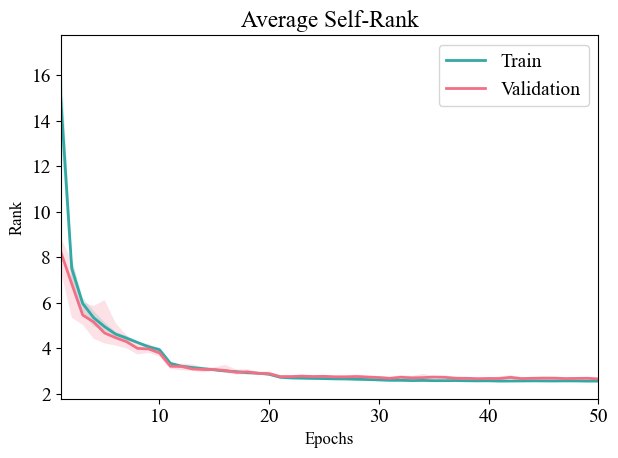

In [19]:
train_arr = np.asarray(cv_results['train_acc_mean_pos'])
val_arr = np.asarray(cv_results['val_acc_mean_pos'])
train_arr.shape, val_arr.shape
plot_train_test_losses(train_arr,val_arr, title="Average Self-Rank", x_label="Epochs", y_label="Rank",
                       min_max_bounds= True, tight_x_lim= True,
                       train_legend = "Train", test_legend = "Validation",
                       save_path=f"results/RUN_{run_name}_{USER}.png")

In [20]:
model = torch.load(f"results/RUN_{run_name}_{USER}_SelfSupervised.pth")

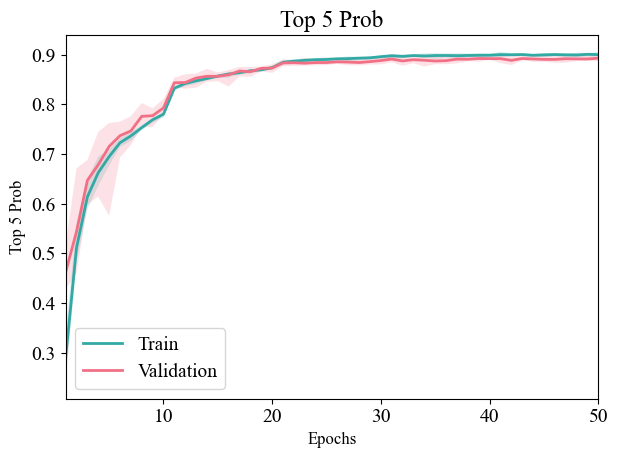

In [21]:
train_arr = np.asarray(cv_results['train_acc_top5'])
val_arr = np.asarray(cv_results['val_acc_top5'])
train_arr.shape, val_arr.shape
plot_train_test_losses(train_arr,val_arr, title="Top 5 Prob", x_label="Epochs", y_label="Top 5 Prob",
                       min_max_bounds= True, tight_x_lim= True,
                       train_legend = "Train", test_legend = "Validation",
                       save_path=f"results/RUN_{run_name}_{USER}.png")

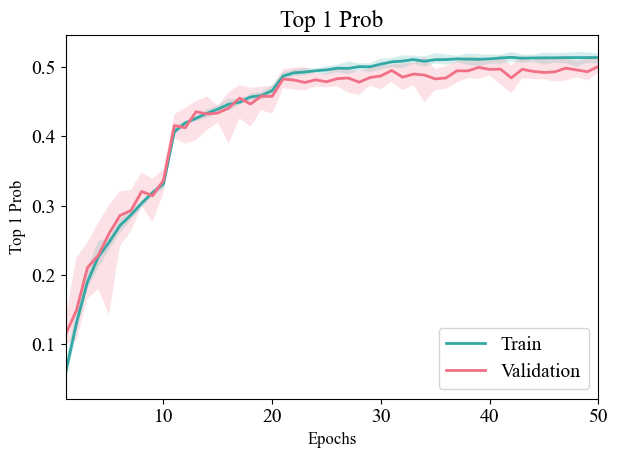

In [22]:
train_arr = np.asarray(cv_results['train_acc_top1'])
val_arr = np.asarray(cv_results['val_acc_top1'])
train_arr.shape, val_arr.shape
plot_train_test_losses(train_arr,val_arr, title="Top 1 Prob", x_label="Epochs", y_label="Top 1 Prob",
                       min_max_bounds= True, tight_x_lim= True,
                       train_legend = "Train", test_legend = "Validation",
                       save_path=f"results/RUN_{run_name}_{USER}.png")

# END
We change the rest if the code worked on full dataset.

In [ ]:
import csv

In [ ]:
# Format the date and time
now = datetime.now()
finish_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", finish_string)

In [ ]:
cv_results["MAE"],cv_results['RMSE'],cv_results["R2"]

In [ ]:
cv_results_full = {}
cv_results_full['MAE_MEAN'] = np.mean(cv_results['MAE'])
cv_results_full['RMSE_MEAN'] = np.mean(cv_results['RMSE'])
cv_results_full['R2_MEAN'] = np.mean(cv_results['R2'])
cv_results_full['MAE_MEAN'],cv_results_full['RMSE_MEAN'],cv_results_full['R2_MEAN']

In [ ]:
cv_results_full['USE_LSTM_BRANCH'] = USE_LSTM_BRANCH
cv_results_full['NUM_CLIMATE_FEATURES'] = NUM_CLIMATE_FEATURES if USE_LSTM_BRANCH else None
cv_results_full['CSV_FILES'] = CSV_FILES if USE_LSTM_BRANCH else None
cv_results_full['NUM_WORKERS'] = NUM_WORKERS
cv_results_full['TRAIN_BATCH_SIZE'] = TRAIN_BATCH_SIZE
cv_results_full['TEST_BATCH_SIZE'] = TEST_BATCH_SIZE
cv_results_full['LEARNING_RATE'] = LEARNING_RATE
cv_results_full['NUM_EPOCHS'] = NUM_EPOCHS
cv_results_full['LR_SCHEDULER'] = LR_SCHEDULER
cv_results_full['CNN_ARCHITECTURE'] = CNN_ARCHITECTURE
cv_results_full['REG_VERSION'] = REG_VERSION
cv_results_full['USE_SPATIAL_ATTENTION'] = USE_SPATIAL_ATTENTION
cv_results_full['Best Seed'] = best_seed
cv_results_full['SEEDS'] = SEEDS
cv_results_full['OC_MAX'] = OC_MAX
cv_results_full['USE_SRTM'] = USE_SRTM
cv_results_full['TIME'] = {"start": start_string, "finish": finish_string}
cv_results_full['cv_results'] = cv_results

In [ ]:
with open(f"results/RUN_{run_name}_{USER}.json", "w") as fp:
    json.dump(cv_results_full, fp, indent=4)

In [ ]:
# READ JSON FILE
# with open("results/my_dict.json", "r") as fp:
#     my_dict = json.load(fp)

# print(my_dict)

# Analysis

## Save Outputs

### Loading the Best Model
Loading the best model from all the coross validation runs.

In [ ]:
load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),filename=f"results/RUN_{run_name}_{USER}.pth.tar")
model.eval()
print("Model loaded")

load saved model

In [ ]:
# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_05_T_16_02_Nafiseh.pth.tar') #LSTM 

# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_03_T_09_41_Nafiseh.pth.tar') #GLAM 

# load_checkpoint(model=model, optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
#                 filename='C:\\Users\\nkakhani\\_Multimodal\\SoilNet-5\\SoilNet\\results\\RUN_D_2023_06_02_T_20_57_Nafiseh.pth.tar') #Base

# model.eval()
# print("Model loaded")

In [ ]:
test_dl_w_id = DataLoader(test_ds_w_id, batch_size=TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [ ]:
# test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/RUN_{run_name}_{USER}.csv")
# test_step_w_id(model=model, data_loader=test_dl_w_id, loss_fn=nn.L1Loss(), verbose=False, csv_file=f"results/onlytest_{run_name}_{USER}.csv")

## Visualize Spatial Attention

In [ ]:
if not USE_SPATIAL_ATTENTION or USE_LSTM_BRANCH:
    raise Exception("The Next Part of the Notebook is only available for the model with Spatial Attention and no LSTM Branch")

In [ ]:
BATCH_N = 1

IMG_IN_BATCH = 2

In [ ]:
batch_loader = BatchLoader(test_dl_w_id)

In [ ]:
batch = batch_loader(BATCH_N)
batch[0].shape, batch[1].shape, len(batch[2])

In [ ]:
import sys
import importlib
importlib.reload(sys.modules['plot_utils'])

In [ ]:
from plot_utils.plot import *
from PIL import Image

In [ ]:
# check if results/attention_maps folder exists if not create it
if not os.path.exists("results/attention_maps"):
    os.makedirs("results/attention_maps")

In [ ]:
ABS_ATT = False
ALPHA = 0.4
with torch.no_grad():
    pid = batch[2][IMG_IN_BATCH]
    print("Point Id:", pid)
    out = model(batch[0].to(device))
    print(out.shape)
    print(model.cnn.glam.local_spatial_att.att_map.shape)
    img_rgb = batch[0][0].permute(1,2,0)[:,:,[3,2,1]].detach().cpu().numpy()
    img_rgb = convert2uint8(normalize(img_rgb))
    
    att_map = model.cnn.glam.local_spatial_att.att_map
    att_map = F.interpolate(att_map, size=(64, 64), mode='bicubic', align_corners=True)[IMG_IN_BATCH].detach().cpu().numpy()[0]
    att_map = np.abs(att_map) if ABS_ATT else att_map
    att_map = convert2uint8(normalize(att_map))   
    
    colormap = cv2.applyColorMap(att_map, cv2.COLORMAP_JET)
    
    img_colormaped = cv2.addWeighted(img_rgb, 1 - ALPHA, colormap, ALPHA, 0)

    display_images(img_rgb, img_colormaped, ["Image", "Attention Map"], f"Local Attention Map Visualization | Point ID: {pid}", figsize=(10,5))
    

    
    
    cv2.imwrite(f"results/attention_maps/final/_{run_name}_{USER}_pid{pid}_img_lcl_colormaped.png", cv2.cvtColor(img_colormaped, cv2.COLOR_RGB2BGR))
    
    
    

In [ ]:
GLOB_ATT_CHANNEL = 510 # ranges between 0 and 511
with torch.no_grad():
    pid = batch[2][IMG_IN_BATCH]
    print("Point Id:", pid)
    out = model(batch[0].to(device))
    print(out.shape)
    print(model.cnn.glam.global_spatial_att.att.shape)
    img_rgb = batch[0][0].permute(1,2,0)[:,:,[3,2,1]].detach().cpu().numpy()
    img_rgb = convert2uint8(normalize(img_rgb))
    
    att_map = model.cnn.glam.global_spatial_att.att
    att_map = F.interpolate(att_map, size=(64, 64), mode='bicubic', align_corners=True)[IMG_IN_BATCH].detach().cpu().numpy()[GLOB_ATT_CHANNEL]
    att_map = np.abs(att_map) if ABS_ATT else att_map
    att_map = convert2uint8(normalize(att_map))   
    
    colormap = cv2.applyColorMap(att_map, cv2.COLORMAP_JET)
    
    img_colormaped = cv2.addWeighted(img_rgb, 1 - ALPHA, colormap, ALPHA, 0)

    display_images(img_rgb, img_colormaped, ["Image", "Attention Map"], f"Global{GLOB_ATT_CHANNEL} Attention Map Visualization | Point ID: {pid}") 
                #    figsize=(10,5), savepath=f"results/attention_maps/final/RUN_{run_name}_{USER}_pid{pid}_glb{GLOB_ATT_CHANNEL}.png")
    
    # # Save img_rgband img_colormaped as jpg files
    # cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_glb{GLOB_ATT_CHANNEL}_rgb.png", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))
    # cv2.imwrite(f"results/attention_maps/RUN_{run_name}_{USER}_pid{pid}_img_glb{GLOB_ATT_CHANNEL}_colormaped.png", cv2.cvtColor(img_colormaped, cv2.COLOR_RGB2BGR))
    
    
    